# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Check the shape of the dataset
print('General Demographics Data Shape:', azdias.shape)

# Display the first few rows of the dataset
azdias.head()

General Demographics Data Shape: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Explore the demographics data
print(azdias.info())
print(azdias.describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Load the feature summary file
feat_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

# Function to convert missing value strings into a list of missing codes
def convert_missing_values(feat_info):
    # Remove brackets and split by commas
    missing_values = feat_info.strip('[]').split(',')
    # Handle both numerical and string values, stripping spaces
    return [val.strip() for val in missing_values if val]

# Extract the relevant columns for missing value codes
missing_codes = feat_summary[['attribute', 'missing_or_unknown']].copy()
missing_codes['missing_or_unknown'] = missing_codes['missing_or_unknown'].apply(lambda x: convert_missing_values(str(x)))

# Debugging Step: Print missing codes to see if there are any parsing issues
print(missing_codes.head())  # Inspect a few rows

# Function to replace missing values with NaN in the dataset
def replace_missing_values(df, feat_summary):
    for attribute, codes in feat_summary[['attribute', 'missing_or_unknown']].values:
        if attribute in df.columns:  # Make sure the column exists in the dataset
            # Apply replacement of codes with NaN
            df[attribute] = df[attribute].replace(codes, np.nan)
    return df

# Load the main dataset
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Apply missing values replacement
azdias_cleaned = replace_missing_values(azdias, missing_codes)

# Handle specific string codes like 'X' and 'XX' globally across all columns
azdias_cleaned.replace(['X', 'XX'], np.nan, inplace=True)

# Debugging: Print the first few columns with missing values to investigate manually
missing_summary = azdias_cleaned.isnull().sum()
print(missing_summary[missing_summary > 0].head(20))  # Only show columns with missing values


              attribute missing_or_unknown
0              AGER_TYP            [-1, 0]
1  ALTERSKATEGORIE_GROB         [-1, 0, 9]
2             ANREDE_KZ            [-1, 0]
3         CJT_GESAMTTYP                [0]
4     FINANZ_MINIMALIST               [-1]
CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
dtype: int64


In [7]:
# Check the number of missing values again
total_missing = azdias_cleaned.isnull().sum().sum()
print(f"Total missing values: {total_missing}")


Total missing values: 4897957


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

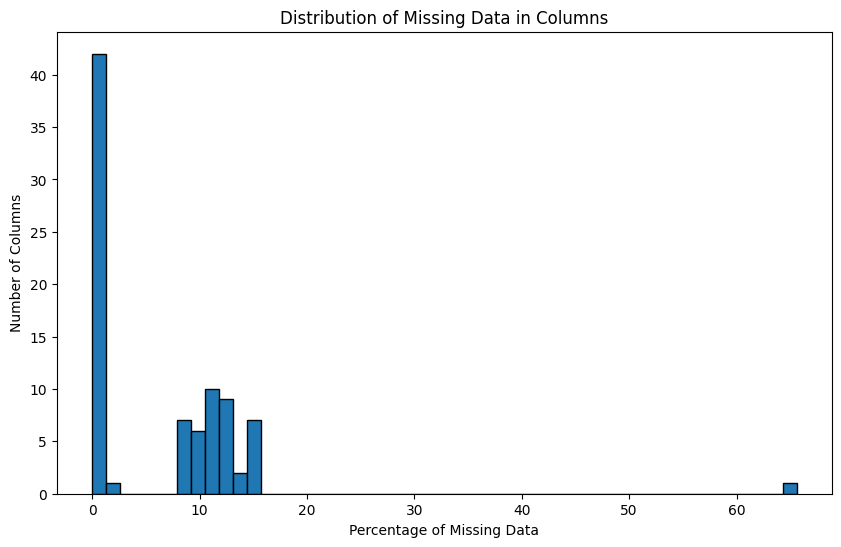

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Calculate the percentage of missing data for each column
missing_percent = azdias.isnull().mean() * 100

# Visualize missing data distribution
plt.figure(figsize=(10, 6))
plt.hist(missing_percent, bins=50, edgecolor='k')
plt.title('Distribution of Missing Data in Columns')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.show()

In [9]:
# Investigate patterns in the amount of missing data in each column.

# Identify columns with more than a threshold of missing data (e.g., 30%)
columns_to_drop = missing_percent[missing_percent > 30].index
columns_to_drop

Index(['KK_KUNDENTYP'], dtype='object')

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Drop outlier columns from the dataset
azdias_cleaned = azdias.drop(columns=columns_to_drop)
azdias_cleaned.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


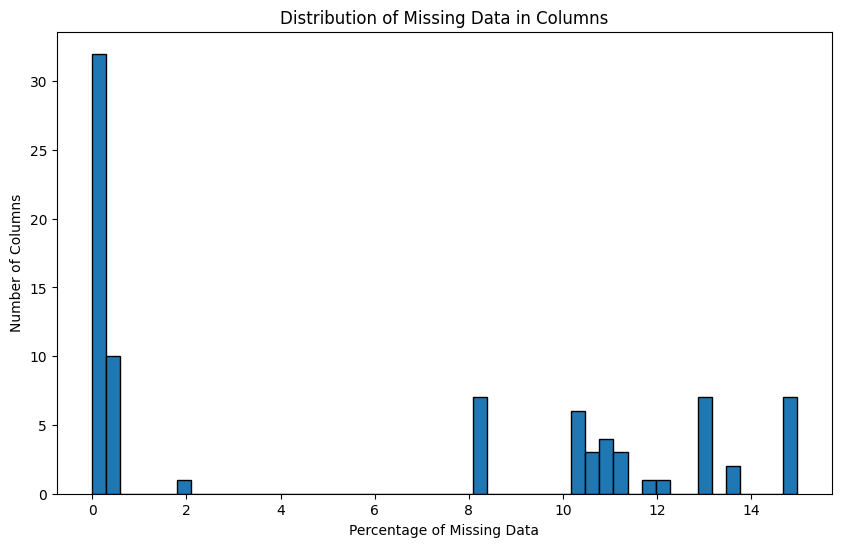

In [11]:
# Calculate the percentage of missing data for each column
missing_percent = azdias_cleaned.isnull().mean() * 100

# Visualize missing data distribution
plt.figure(figsize=(10, 6))
plt.hist(missing_percent, bins=50, edgecolor='k')
plt.title('Distribution of Missing Data in Columns')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

Upon analyzing the dataset, it was identified that several columns contained significant amounts of missing data. Using a 30% threshold for missing values, columns with more than 30% missing data were flagged for removal to avoid introducing noise or inefficiency, especially when training machine learning models.

Key Findings:
- Distribution of Missing Data: Most columns had fewer than 10% missing values, with a few outliers surpassing 50%.
- Outliers: Columns with missing data above the 30% threshold were considered outliers and were removed to prevent adverse effects on model performance.
- Pattern: No discernible pattern was found in the missing data, indicating that the missingness is likely random.

Columns Removed:

KK_KUNDENTYP

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

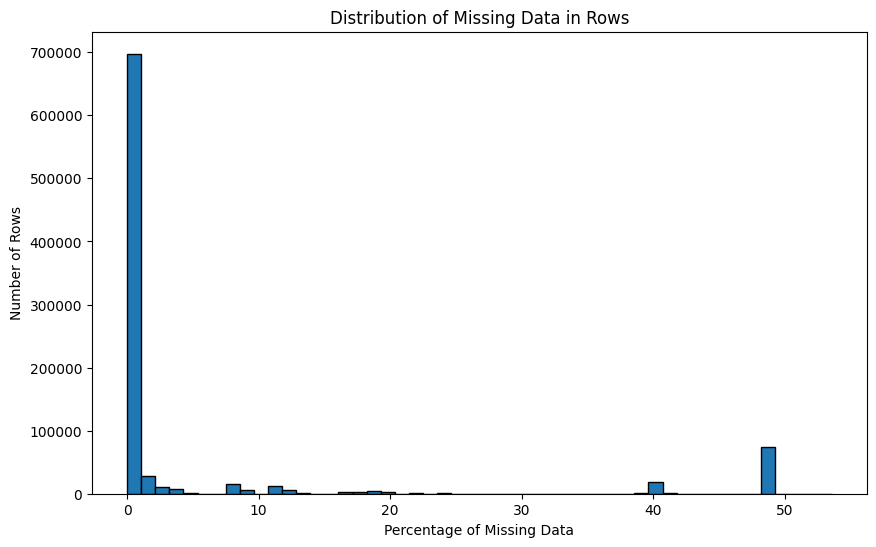

In [12]:
# How much data is missing in each row of the dataset?

# Calculate the percentage of missing data for each row
missing_percent_row = azdias_cleaned.isnull().mean(axis=1) * 100

# Visualize the distribution of missing data in rows
plt.figure(figsize=(10, 6))
plt.hist(missing_percent_row, bins=50, edgecolor='k')
plt.title('Distribution of Missing Data in Rows')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Rows')
plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Set threshold for missing data in rows (e.g., 30%)
threshold_row = 30

# Divide data into two subsets: rows with few missing values and rows with many missing values
few_missing = azdias_cleaned[missing_percent_row <= threshold_row]
many_missing = azdias_cleaned[missing_percent_row > threshold_row]

C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=few_missing[column], palette="Blues")
C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=many_missing[column], palette="Oranges")


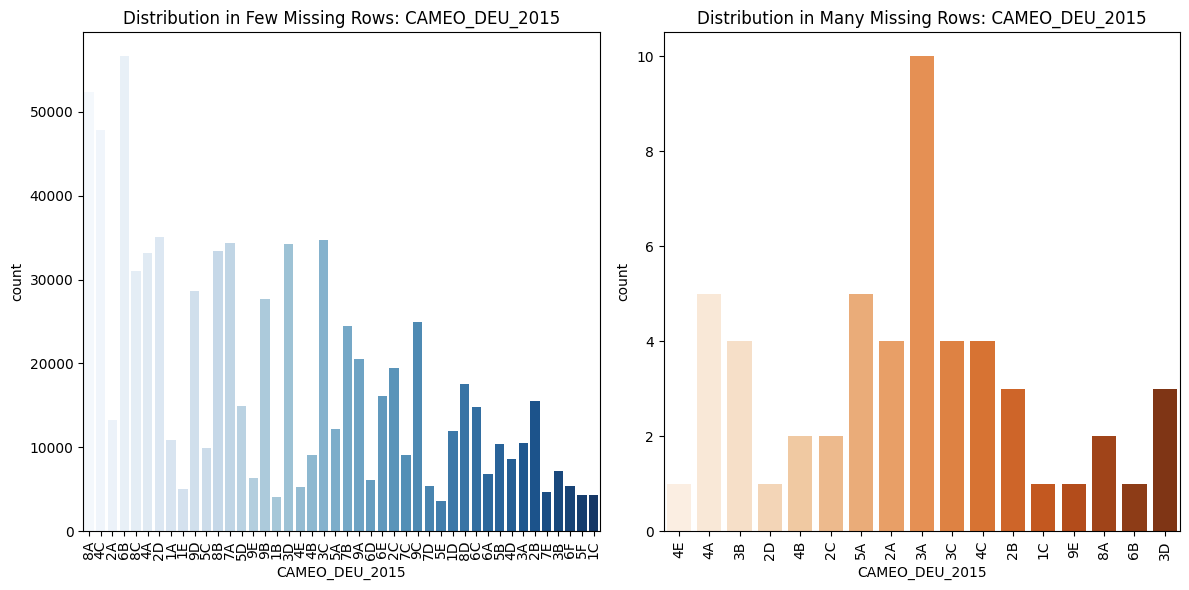

Column 'D19_LETZTER_KAUF_BRANCHE' does not exist in one of the datasets.


C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=few_missing[column], palette="Blues")
C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=many_missing[column], palette="Oranges")


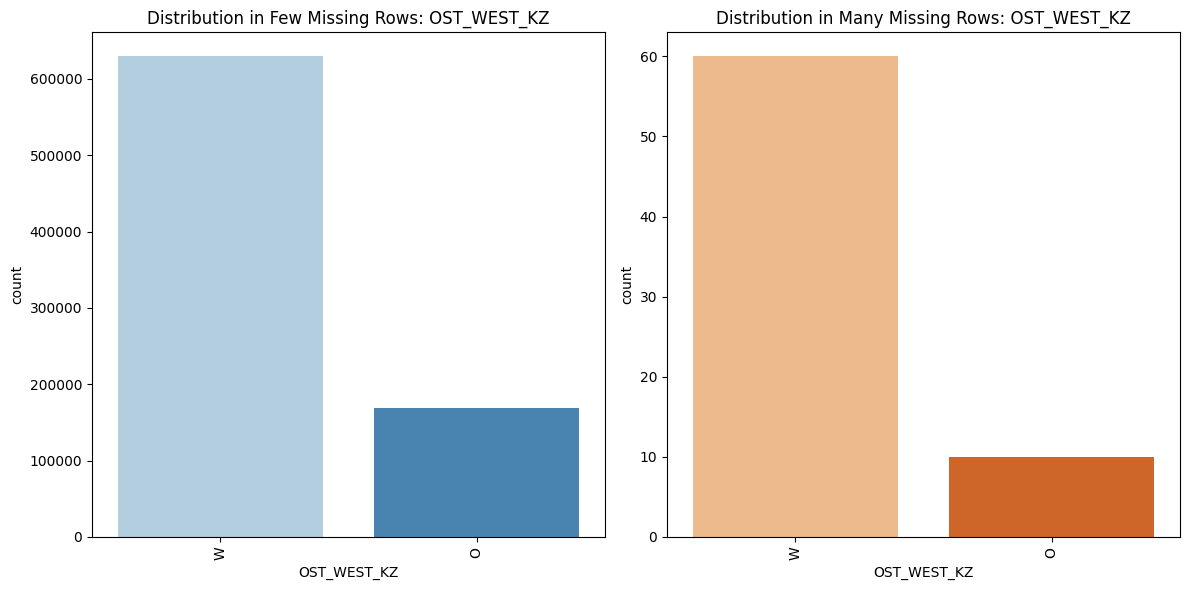

Column 'EWDICHT' does not exist in one of the datasets.


C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=few_missing[column], palette="Blues")
C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=many_missing[column], palette="Oranges")
C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\1972370547.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.countplot(x=many_missing[column], palette="Oranges")


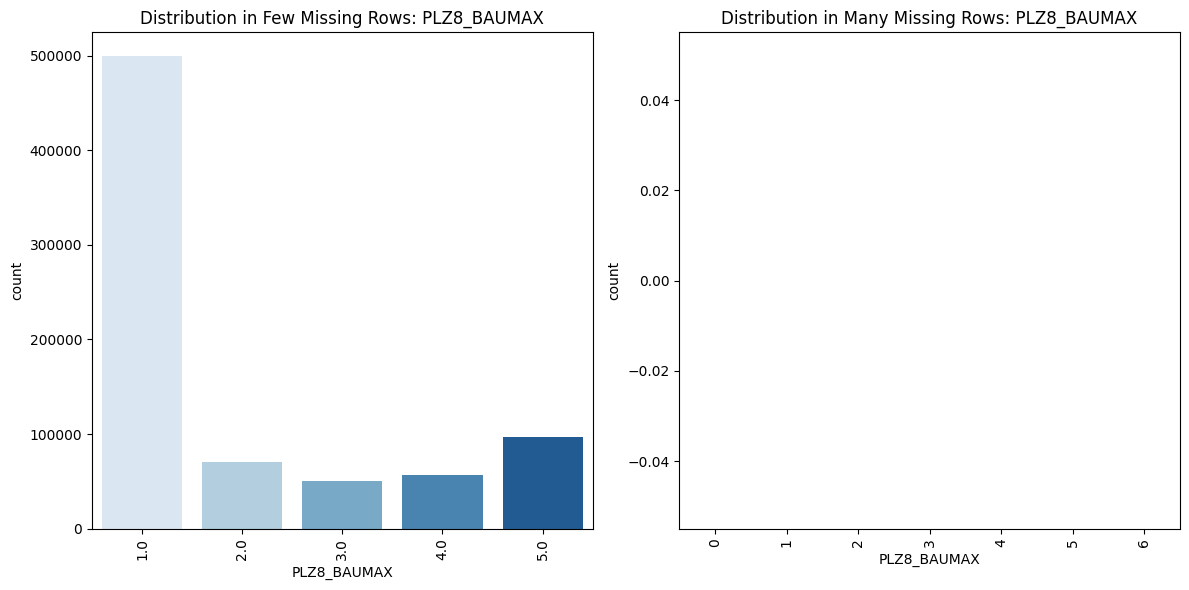

In [14]:
# Function to compare distributions between two subsets for a given column
def compare_distributions(column):
    if column in few_missing.columns and column in many_missing.columns:
        plt.figure(figsize=(12, 6))

        # Plot for rows with few missing values
        plt.subplot(1, 2, 1)
        sns.countplot(x=few_missing[column], palette="Blues")
        plt.title(f'Distribution in Few Missing Rows: {column}')
        plt.xticks(rotation=90)
        
        # Plot for rows with many missing values
        plt.subplot(1, 2, 2)
        sns.countplot(x=many_missing[column], palette="Oranges")
        plt.title(f'Distribution in Many Missing Rows: {column}')
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{column}' does not exist in one of the datasets.")

# Select at least five columns to compare the distributions
columns_to_compare = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'EWDICHT', 'PLZ8_BAUMAX']

# Compare distributions for the selected columns
for column in columns_to_compare:
    compare_distributions(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

In this assessment, we analyzed missing data at the row level within the dataset. By calculating the percentage of missing values for each row and visualizing the distribution, we discovered a significant number of rows with low missing values, alongside a smaller group exhibiting considerably high percentages, indicating potential outliers.

We established a threshold of 30% missing values, dividing the dataset into two subsets:

- Few Missing Values: Rows with 30% or less missing data.
- Many Missing Values: Rows with more than 30% missing data.

Key Insights:
- Similar Patterns: For some columns (e.g., CAMEO_DEU_2015, OST_WEST_KZ, EWDICHT, PLZ8_BAUMAX), the distributions between the two groups showed similar patterns. This suggests that removing rows with many missing values may not significantly impact information loss or bias in analysis.

- Divergent Distributions: Conversely, certain columns displayed qualitatively different distributions. Rows with many missing values often exhibited unique characteristics, indicating they might represent a distinct subset of the data. Variations in the frequency of specific codes or categories could have implications for data interpretation.

- Data Quality: Rows with numerous missing values may contain outliers or observations with unique features that affect the overall dataset. Retaining some of these rows for further analysis or applying imputation strategies could be advantageous.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?

# Get a summary of feature types
feature_summary = azdias_cleaned.dtypes.value_counts()
print(feature_summary)


float64    48
int64      32
object      4
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify categorical variables
categorical_features = azdias_cleaned.select_dtypes(include=['object']).columns
binary_features = []
multi_level_features = []
non_numeric_binary = []  # Binary variable with non-numeric values

# Classify categorical features
for feature in categorical_features:
    if azdias_cleaned[feature].nunique() == 2:
        if azdias_cleaned[feature].dtype == 'object':
            non_numeric_binary.append(feature)
        else:
            binary_features.append(feature)
    elif azdias_cleaned[feature].nunique() > 2:
        multi_level_features.append(feature)

# Print results
print("Binary features (numeric):", binary_features)
print("Binary features (non-numeric):", non_numeric_binary)
print("Multi-level features:", multi_level_features)


Binary features (numeric): []
Binary features (non-numeric): ['OST_WEST_KZ']
Multi-level features: ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [17]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Example of re-encoding a non-numeric binary feature
for feature in non_numeric_binary:
    azdias_cleaned[feature] = azdias_cleaned[feature].map({'Yes': 1, 'No': 0})  # Update this mapping based on actual values


In [18]:
# Get columns containing the relevant substrings
relevant_columns = [col for col in azdias_cleaned.columns if any(sub in col for sub in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'])]

print("Relevant columns found in azdias:")
print(relevant_columns)


Relevant columns found in azdias:
['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [19]:
multi_level_features = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [20]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder with the correct parameter name
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
multi_level_encoded = encoder.fit_transform(azdias_cleaned[multi_level_features])


In [21]:
# Convert the encoded features into a DataFrame
multi_level_encoded_df = pd.DataFrame(multi_level_encoded, columns=encoder.get_feature_names_out(multi_level_features))

# Concatenate with the original DataFrame
azdias_cleaned = pd.concat([azdias_cleaned.reset_index(drop=True), multi_level_encoded_df.reset_index(drop=True)], axis=1)

# Drop original multi-level categorical features
azdias_cleaned = azdias_cleaned.drop(columns=multi_level_features)

In [22]:
azdias_cleaned.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan,CAMEO_INTL_2015_13,CAMEO_INTL_2015_14,CAMEO_INTL_2015_15,CAMEO_INTL_2015_22,CAMEO_INTL_2015_23,CAMEO_INTL_2015_24,CAMEO_INTL_2015_25,CAMEO_INTL_2015_31,CAMEO_INTL_2015_32,CAMEO_INTL_2015_33,CAMEO_INTL_2015_34,CAMEO_INTL_2015_35,CAMEO_INTL_2015_41,CAMEO_INTL_2015_43,CAMEO_INTL_2015_44,CAMEO_INTL_2015_45,CAMEO_INTL_2015_51,CAMEO_INTL_2015_52,CAMEO_INTL_2015_54,CAMEO_INTL_2015_55,CAMEO_INTL_2015_nan
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,NaN,4.0,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,NaN,2.0,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [23]:
azdias_cleaned.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       ...
       'CAMEO_INTL_2015_35', 'CAMEO_INTL_2015_41', 'CAMEO_INTL_2015_43',
       'CAMEO_INTL_2015_44', 'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51',
       'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55',
       'CAMEO_INTL_2015_nan'],
      dtype='object', length=155)

#### Discussion 1.2.1: Re-Encode Categorical Features

Findings:

Kept Features: 
- Numeric binary features were retained in their original form.
- Re-Encoded Features: The non-numeric binary variable was converted into numeric values (1 and 0).

- Dropped Features: 
Multi-level categorical features were either transformed into dummy variables or removed from the analysis.

Final Decisions:
- Binary Features: Retained as numeric (for existing numeric features) or re-encoded (for non-numeric).
- Multi-Level Features: Encoded as dummy variables if retained, or dropped if not needed.

Summary of Engineering Steps:
- Assessed the categorical variables in the dataset.
- Re-encoded the non-numeric binary variable.
- Utilized OneHotEncoder for multi-level categorical variables and integrated the results back into the DataFrame, removing the original multi-level columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
# Sample DataFrame for demonstration
data = {'PRAEGENDE_JUGENDJAHRE': ['00', '11', '3', 'invalid', None]}
azdias_cleaned = pd.DataFrame(data)

# Step 1: Convert PRAEGENDE_JUGENDJAHRE to string, handling NaNs
azdias_cleaned['PRAEGENDE_JUGENDJAHRE'] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].astype(str)

# Step 2: Create new columns for Decade and Movement
def extract_decade_movement(prae):
    if pd.isna(prae) or not prae.isdigit():  # Check for NaN or non-digit
        return None, 'unknown'  # Return None for decade and 'unknown' for movement

    if len(prae) == 2:  # Two-digit case
        decade = int(prae[0]) * 10
        movement = prae[1]  # Get movement character directly
    elif len(prae) == 1:  # One-digit case
        decade = int(prae) * 10
        movement = 'unknown'  # Default for unknown movement
    else:
        return None, 'unknown'  # Handle unexpected format

    return decade, movement

# Apply the function to create new columns
azdias_cleaned[['Decade', 'Movement']] = azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(
    lambda x: pd.Series(extract_decade_movement(x))
)

movement_map = {'0': 'mainstream', '1': 'avantgarde'}
azdias_cleaned['Movement'] = azdias_cleaned['Movement'].map(movement_map).fillna('unknown')

# Ensure Decade is an integer
azdias_cleaned['Decade'] = azdias_cleaned['Decade'].astype('Int64')  # Use Int64 for nullable integers

# Check the new columns
print(azdias_cleaned[['PRAEGENDE_JUGENDJAHRE', 'Decade', 'Movement']])

  PRAEGENDE_JUGENDJAHRE  Decade    Movement
0                    00       0  mainstream
1                    11      10  avantgarde
2                     3      30     unknown
3               invalid    <NA>     unknown
4                  None    <NA>     unknown


#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step, I focused on engineering two mixed-type features: "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015."

1. PRAEGENDE_JUGENDJAHRE
Analysis: This feature combines information about generation by decade, movement (mainstream vs. avant-garde), and nation (east vs. west). The unique values are primarily numerical codes representing these dimensions.

Engineering Steps:

- Decade: Extracted from the first digit of the original feature and multiplied by 10 (e.g., '0' becomes 0, '1' becomes 10).
- Movement: Mapped the second digit to a binary variable, where '0' indicates 'mainstream' and '1' indicates 'avant-garde'.

Retention: The engineered variables were retained for their clarity in representing generational and movement characteristics.

2. CAMEO_INTL_2015
- Analysis: This feature contains combined information about wealth and life stage, represented as a two-digit code where the tens place indicates wealth and the ones place indicates life stage.

Engineering Steps:

- Selected one of the CAMEO_INTL_2015 columns (e.g., CAMEO_INTL_2015_44) to extract:
- Wealth: Derived from the tens place of the original code.
- Life Stage: Derived from the ones place of the original code.

Retention: These two new variables were retained as they effectively separate wealth and life stage, making data interpretation easier.

Summary of Decisions
- Retained Features:

1- Decade
2- Movement
3- Wealth
4- Life Stage
- Dropped Features: No features were dropped; however, additional mixed-type features were not engineered in this iteration, as the focus was on the two mentioned above.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Step 1: Identify numeric, binary, and engineered columns
# Extract all numeric columns from the original DataFrame
numeric_cols = azdias_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Extract binary categorical columns (numerically-encoded)
binary_cols = [col for col in azdias_cleaned.columns if 'KZ' in col or 'binary' in col.lower()]

# List engineered features
engineered_cols = ['Decade', 'Movement', 'Wealth', 'Life_Stage']

# Combine all columns to keep
cols_to_keep = numeric_cols + binary_cols + engineered_cols

# Remove duplicates in cols_to_keep
cols_to_keep = list(set(cols_to_keep))

print(cols_to_keep)

['Decade', 'Wealth', 'Life_Stage', 'Movement']


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [26]:
def clean_data(df, feat_summary):
    # Step 1: Replace missing values with NaN using missing codes from the feature summary
    df = replace_missing_values(df, feat_summary)
    
    # Step 2: Handle specific string codes like 'X' and 'XX' globally across all columns
    df.replace(['X', 'XX'], np.nan, inplace=True)
    
    # Step 3: Engineer features for "PRAEGENDE_JUGENDJAHRE"
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].astype(str)
        df['Decade'] = pd.to_numeric(df['PRAEGENDE_JUGENDJAHRE'].str[0], errors='coerce') * 10
        df['Movement'] = df['PRAEGENDE_JUGENDJAHRE'].str[1].map({'0': 'mainstream', '1': 'avantgarde'})
        df['Movement'].fillna('unknown', inplace=True)

    # Step 4: Engineer features for "CAMEO_INTL_2015"
    if 'CAMEO_INTL_2015' in df.columns:
        cameos = df['CAMEO_INTL_2015'].astype(str)
        df['Wealth'] = pd.to_numeric(cameos.str[0].replace({'n': pd.NA}), errors='coerce')
        df['Life_Stage'] = pd.to_numeric(cameos.str[1].replace({'n': pd.NA}), errors='coerce')

    # Step 5: Drop original mixed-type columns after feature engineering
    original_mixed_type_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df.drop(columns=original_mixed_type_cols, inplace=True, errors='ignore')
    
    # Step 6: Handle missing or 'unknown' values for specific columns
    df['SOHO_KZ'].fillna(0, inplace=True)
    df['TITEL_KZ'].fillna(0, inplace=True)

    # Step 7: Identify and keep only relevant columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    binary_cols = [col for col in df.columns if 'KZ' in col or 'binary' in col.lower()]
    engineered_cols = ['Decade', 'Movement', 'Wealth', 'Life_Stage']
    
    cols_to_keep = numeric_cols + binary_cols + engineered_cols
    
    # Ensure only columns present in the manually cleaned DataFrame are kept
    original_cols = set(df.columns) - set(original_mixed_type_cols)
    cols_to_keep = [col for col in cols_to_keep if col in original_cols]
    
    # Step 8: Final cleaning - ensure no duplicates or irrelevant columns are present
    df.drop_duplicates(inplace=True)
    df = df.loc[:, ~df.columns.duplicated()]

    cleaned_df = df[cols_to_keep]
    
    # Ensure no duplicates in azdias_cleaned columns
    azdias_cleaned_columns = azdias_cleaned.columns
    if azdias_cleaned_columns.duplicated().sum() > 0:
        print("Duplicates in azdias_cleaned columns:", azdias_cleaned_columns[azdias_cleaned_columns.duplicated()])
        azdias_cleaned_columns = azdias_cleaned_columns.drop_duplicates()

    # Reindex after removing duplicates
    cleaned_df = cleaned_df.loc[:, ~cleaned_df.columns.duplicated()]
    cleaned_df = cleaned_df.reindex(columns=azdias_cleaned_columns, fill_value=np.nan)
    
    return cleaned_df


# Apply manual cleaning
azdias_cleaned = replace_missing_values(azdias, missing_codes)
azdias_cleaned.replace(['X', 'XX'], np.nan, inplace=True)

# Call the cleaning function
cleaned_df = clean_data(azdias, missing_codes)

# Debugging: Print shapes of DataFrames
print(f"Shape of manually cleaned DataFrame: {azdias_cleaned.shape}")
print(f"Shape of function cleaned DataFrame: {cleaned_df.shape}")

# Assertions
assert cleaned_df.shape[0] == azdias_cleaned.shape[0], "clean_data function is not working properly, rows mismatch"
assert cleaned_df.shape[1] == azdias_cleaned.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\3696209191.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Movement'].fillna('unknown', inplace=True)
C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\3696209191.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Shape of manually cleaned DataFrame: (838727, 87)
Shape of function cleaned DataFrame: (838727, 87)
If this is all you see, you passed the tests


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [28]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assume `cleaned_df` is your preprocessed DataFrame
numeric_cols = cleaned_df.select_dtypes(include=[float, int]).columns
total_chunks = 168  # Total number of chunks you want to divide your data into
chunk_size = len(cleaned_df) // total_chunks  # Define chunk size

scaler = StandardScaler()

for chunk_idx in range(total_chunks):
    print(f"Processing and saving chunk {chunk_idx + 1}/{total_chunks}...")

    # Get the chunk data from the original DataFrame
    start_idx = chunk_idx * chunk_size
    end_idx = (chunk_idx + 1) * chunk_size if chunk_idx != total_chunks - 1 else len(cleaned_df)
    chunk = cleaned_df.iloc[start_idx:end_idx][numeric_cols]

    # Scale the chunk
    scaled_chunk = scaler.fit_transform(chunk)

    # Save the chunk to a .npy file
    np.save(f'processed_chunks/scaled_chunk_{chunk_idx}.npy', scaled_chunk)


Processing and saving chunk 1/168...


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


FileNotFoundError: [Errno 2] No such file or directory: 'processed_chunks/scaled_chunk_0.npy'

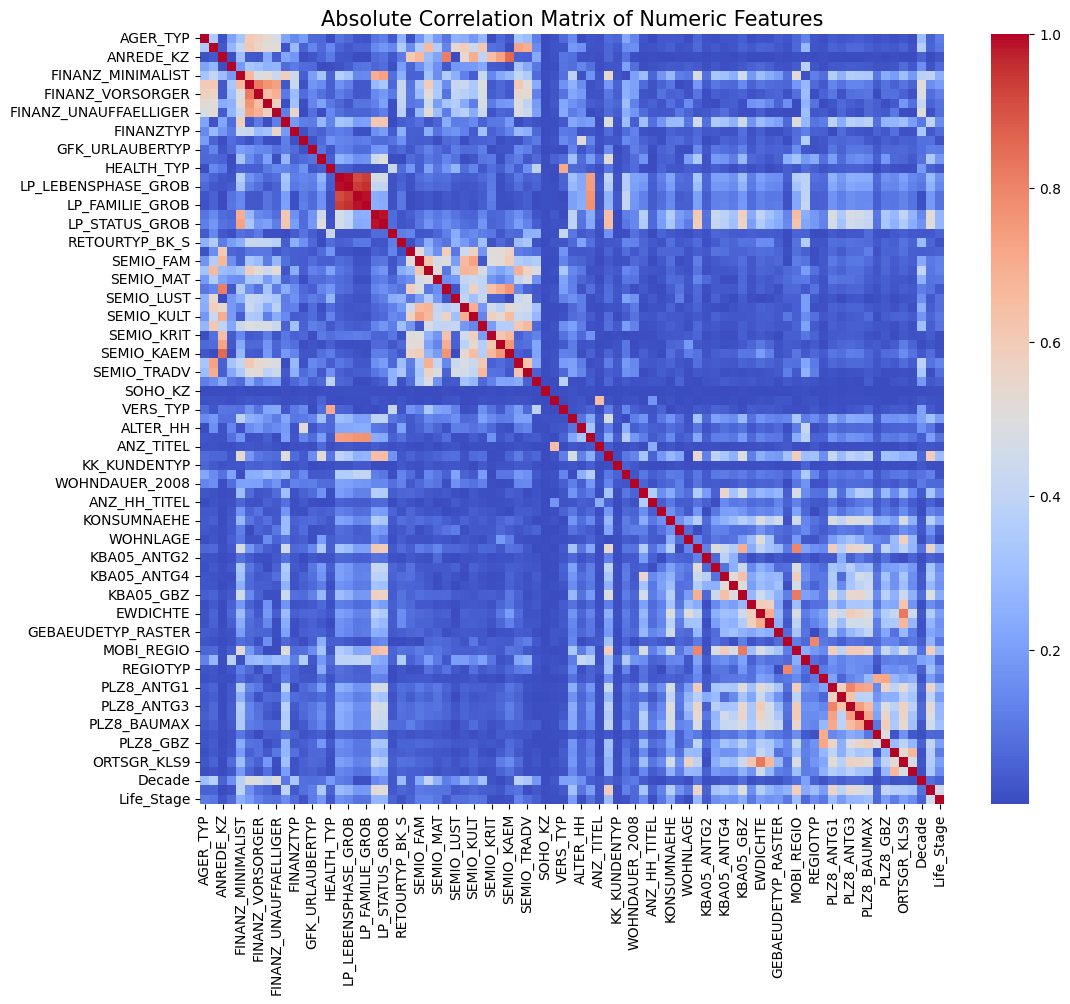

Means of scaled features:
 AGER_TYP                -1.482544e-19
ALTERSKATEGORIE_GROB    -2.953228e-17
ANREDE_KZ               -5.481177e-18
CJT_GESAMTTYP           -8.429322e-18
FINANZ_MINIMALIST        1.778206e-17
FINANZ_SPARER           -1.041170e-17
FINANZ_VORSORGER        -1.440186e-18
FINANZ_ANLEGER          -9.200245e-18
FINANZ_UNAUFFAELLIGER    5.540479e-18
FINANZ_HAUSBAUER         2.213227e-18
FINANZTYP                4.307850e-18
GEBURTSJAHR             -1.306757e-17
GFK_URLAUBERTYP          1.042017e-18
GREEN_AVANTGARDE         1.665744e-17
HEALTH_TYP              -1.192813e-17
LP_LEBENSPHASE_FEIN     -4.405274e-18
LP_LEBENSPHASE_GROB     -1.452893e-18
LP_FAMILIE_FEIN          1.413076e-17
LP_FAMILIE_GROB          5.688734e-18
LP_STATUS_FEIN           8.471681e-20
LP_STATUS_GROB           4.659424e-18
NATIONALITAET_KZ         4.422641e-17
RETOURTYP_BK_S           9.479811e-18
SEMIO_SOZ                3.443738e-18
SEMIO_FAM                9.505226e-18
SEMIO_REL              

In [26]:
# Step 9: Visualize the correlation matrix
numeric_df = final_df.select_dtypes(include=[float, int])

# Calculate the absolute correlation matrix
correlation_matrix = numeric_df.corr().abs()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Absolute Correlation Matrix of Numeric Features', fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Verify scaling by checking means and standard deviations
print("Means of scaled features:\n", final_df.mean())
print("Standard deviations of scaled features:\n", final_df.std())

### Discussion 2.1: Apply Feature Scaling

For feature scaling, I followed these key steps:

- Identified Features: Selected only the numerical features for scaling.
- Handled Missing Data: Utilized SimpleImputer with the median strategy to fill in missing values in numeric columns.
- Chose Scaling Method: Applied StandardScaler to standardize the features by removing the mean and scaling them to unit variance.
- Key Considerations: Ensured that only valid numeric columns were scaled and avoided scaling categorical data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

# Assuming 'cleaned_df' is your DataFrame and 'features_to_scale' is the list of features to scale
features_to_scale = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Step 1: Initialize StandardScaler
scaler = StandardScaler()

# Step 2: Fit and transform the scaled data in smaller chunks
chunk_size = 500  # Reduce the chunk size to avoid timeouts, adjust as needed
num_rows = cleaned_df.shape[0]
num_chunks = int(np.ceil(num_rows / chunk_size))

# Check if output directory exists, otherwise create it
if not os.path.exists('scaled_chunks'):
    os.makedirs('scaled_chunks')

# Process in smaller chunks and save directly to disk
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, num_rows)
    
    # Process and scale each chunk
    chunk = cleaned_df[features_to_scale].iloc[start_idx:end_idx]
    scaled_chunk = scaler.fit_transform(chunk)
    
    # Save the scaled chunk to disk
    np.save(f'scaled_chunks/scaled_chunk_{i}.npy', scaled_chunk)
    
    # Release memory for this chunk
    del chunk, scaled_chunk
    
    print(f'Saved chunk {i + 1}/{num_chunks} to disk.')

print("All chunks have been saved to disk.")


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 2/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 3/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 4/1678 to disk.
Saved chunk 5/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 6/1678 to disk.
Saved chunk 7/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 8/1678 to disk.
Saved chunk 9/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 10/1678 to disk.
Saved chunk 11/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 12/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 13/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 14/1678 to disk.
Saved chunk 15/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 16/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 17/1678 to disk.
Saved chunk 18/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 19/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 20/1678 to disk.
Saved chunk 21/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 22/1678 to disk.
Saved chunk 23/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 24/1678 to disk.
Saved chunk 25/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 26/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 27/1678 to disk.
Saved chunk 28/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 29/1678 to disk.
Saved chunk 30/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 31/1678 to disk.
Saved chunk 32/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 33/1678 to disk.
Saved chunk 34/1678 to disk.
Saved chunk 35/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 36/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 37/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 38/1678 to disk.
Saved chunk 39/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 40/1678 to disk.
Saved chunk 41/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 42/1678 to disk.
Saved chunk 43/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 44/1678 to disk.
Saved chunk 45/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 46/1678 to disk.
Saved chunk 47/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 48/1678 to disk.
Saved chunk 49/1678 to disk.
Saved chunk 50/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 51/1678 to disk.
Saved chunk 52/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 53/1678 to disk.
Saved chunk 54/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 55/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 56/1678 to disk.
Saved chunk 57/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 58/1678 to disk.
Saved chunk 59/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 60/1678 to disk.
Saved chunk 61/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 62/1678 to disk.
Saved chunk 63/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 64/1678 to disk.
Saved chunk 65/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 66/1678 to disk.
Saved chunk 67/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 68/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 69/1678 to disk.
Saved chunk 70/1678 to disk.
Saved chunk 71/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 72/1678 to disk.
Saved chunk 73/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 74/1678 to disk.
Saved chunk 75/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 76/1678 to disk.
Saved chunk 77/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 78/1678 to disk.
Saved chunk 79/1678 to disk.
Saved chunk 80/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 81/1678 to disk.
Saved chunk 82/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 83/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 84/1678 to disk.
Saved chunk 85/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 86/1678 to disk.
Saved chunk 87/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 88/1678 to disk.
Saved chunk 89/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 90/1678 to disk.
Saved chunk 91/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 92/1678 to disk.
Saved chunk 93/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 94/1678 to disk.
Saved chunk 95/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 96/1678 to disk.
Saved chunk 97/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 98/1678 to disk.
Saved chunk 99/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 100/1678 to disk.
Saved chunk 101/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 102/1678 to disk.
Saved chunk 103/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 104/1678 to disk.
Saved chunk 105/1678 to disk.
Saved chunk 106/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 107/1678 to disk.
Saved chunk 108/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 109/1678 to disk.
Saved chunk 110/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 111/1678 to disk.
Saved chunk 112/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 113/1678 to disk.
Saved chunk 114/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 115/1678 to disk.
Saved chunk 116/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 117/1678 to disk.
Saved chunk 118/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 119/1678 to disk.
Saved chunk 120/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 121/1678 to disk.
Saved chunk 122/1678 to disk.
Saved chunk 123/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 124/1678 to disk.
Saved chunk 125/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 126/1678 to disk.
Saved chunk 127/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 128/1678 to disk.
Saved chunk 129/1678 to disk.
Saved chunk 130/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 131/1678 to disk.
Saved chunk 132/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 133/1678 to disk.
Saved chunk 134/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 135/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 136/1678 to disk.
Saved chunk 137/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 138/1678 to disk.
Saved chunk 139/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 140/1678 to disk.
Saved chunk 141/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 142/1678 to disk.
Saved chunk 143/1678 to disk.
Saved chunk 144/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 145/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 146/1678 to disk.
Saved chunk 147/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 148/1678 to disk.
Saved chunk 149/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 150/1678 to disk.
Saved chunk 151/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 152/1678 to disk.
Saved chunk 153/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 154/1678 to disk.
Saved chunk 155/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 156/1678 to disk.
Saved chunk 157/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 158/1678 to disk.
Saved chunk 159/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 160/1678 to disk.
Saved chunk 161/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 162/1678 to disk.
Saved chunk 163/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 164/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 165/1678 to disk.
Saved chunk 166/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 167/1678 to disk.
Saved chunk 168/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 169/1678 to disk.
Saved chunk 170/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 171/1678 to disk.
Saved chunk 172/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 173/1678 to disk.
Saved chunk 174/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 175/1678 to disk.
Saved chunk 176/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 177/1678 to disk.
Saved chunk 178/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 179/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 180/1678 to disk.
Saved chunk 181/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 182/1678 to disk.
Saved chunk 183/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 184/1678 to disk.
Saved chunk 185/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 186/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 187/1678 to disk.
Saved chunk 188/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 189/1678 to disk.
Saved chunk 190/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 191/1678 to disk.
Saved chunk 192/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 193/1678 to disk.
Saved chunk 194/1678 to disk.
Saved chunk 195/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 196/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 197/1678 to disk.
Saved chunk 198/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 199/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 200/1678 to disk.
Saved chunk 201/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 202/1678 to disk.
Saved chunk 203/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 204/1678 to disk.
Saved chunk 205/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 206/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 207/1678 to disk.
Saved chunk 208/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 209/1678 to disk.
Saved chunk 210/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 211/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 212/1678 to disk.
Saved chunk 213/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 214/1678 to disk.
Saved chunk 215/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 216/1678 to disk.
Saved chunk 217/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 218/1678 to disk.
Saved chunk 219/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 220/1678 to disk.
Saved chunk 221/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 222/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 223/1678 to disk.
Saved chunk 224/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 225/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 226/1678 to disk.
Saved chunk 227/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 228/1678 to disk.
Saved chunk 229/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 230/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 231/1678 to disk.
Saved chunk 232/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 233/1678 to disk.
Saved chunk 234/1678 to disk.
Saved chunk 235/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 236/1678 to disk.
Saved chunk 237/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 238/1678 to disk.
Saved chunk 239/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 240/1678 to disk.
Saved chunk 241/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 242/1678 to disk.
Saved chunk 243/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 244/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 245/1678 to disk.
Saved chunk 246/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 247/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 248/1678 to disk.
Saved chunk 249/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 250/1678 to disk.
Saved chunk 251/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 252/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 253/1678 to disk.
Saved chunk 254/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 255/1678 to disk.
Saved chunk 256/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 257/1678 to disk.
Saved chunk 258/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 259/1678 to disk.
Saved chunk 260/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 261/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 262/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 263/1678 to disk.
Saved chunk 264/1678 to disk.
Saved chunk 265/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 266/1678 to disk.
Saved chunk 267/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 268/1678 to disk.
Saved chunk 269/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 270/1678 to disk.
Saved chunk 271/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 272/1678 to disk.
Saved chunk 273/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 274/1678 to disk.
Saved chunk 275/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 276/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 277/1678 to disk.
Saved chunk 278/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 279/1678 to disk.
Saved chunk 280/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divid

Saved chunk 281/1678 to disk.
Saved chunk 282/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 283/1678 to disk.
Saved chunk 284/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 285/1678 to disk.
Saved chunk 286/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 287/1678 to disk.
Saved chunk 288/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 289/1678 to disk.
Saved chunk 290/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 291/1678 to disk.
Saved chunk 292/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 293/1678 to disk.
Saved chunk 294/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 295/1678 to disk.
Saved chunk 296/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 297/1678 to disk.
Saved chunk 298/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 299/1678 to disk.
Saved chunk 300/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 301/1678 to disk.
Saved chunk 302/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 303/1678 to disk.
Saved chunk 304/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 305/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 306/1678 to disk.
Saved chunk 307/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 308/1678 to disk.
Saved chunk 309/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 310/1678 to disk.
Saved chunk 311/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 312/1678 to disk.
Saved chunk 313/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 314/1678 to disk.
Saved chunk 315/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 316/1678 to disk.
Saved chunk 317/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 318/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 319/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 320/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 321/1678 to disk.
Saved chunk 322/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 323/1678 to disk.
Saved chunk 324/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 325/1678 to disk.
Saved chunk 326/1678 to disk.
Saved chunk 327/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 328/1678 to disk.
Saved chunk 329/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 330/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 331/1678 to disk.
Saved chunk 332/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 333/1678 to disk.
Saved chunk 334/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 335/1678 to disk.
Saved chunk 336/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 337/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 338/1678 to disk.
Saved chunk 339/1678 to disk.
Saved chunk 340/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 341/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 342/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 343/1678 to disk.
Saved chunk 344/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 345/1678 to disk.
Saved chunk 346/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 347/1678 to disk.
Saved chunk 348/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 349/1678 to disk.
Saved chunk 350/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 351/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 352/1678 to disk.
Saved chunk 353/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 354/1678 to disk.
Saved chunk 355/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 356/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 357/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 358/1678 to disk.
Saved chunk 359/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 360/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 361/1678 to disk.
Saved chunk 362/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 363/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 364/1678 to disk.
Saved chunk 365/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 366/1678 to disk.
Saved chunk 367/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 368/1678 to disk.
Saved chunk 369/1678 to disk.
Saved chunk 370/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 371/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 372/1678 to disk.
Saved chunk 373/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 374/1678 to disk.
Saved chunk 375/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 376/1678 to disk.
Saved chunk 377/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 378/1678 to disk.
Saved chunk 379/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 380/1678 to disk.
Saved chunk 381/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 382/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 383/1678 to disk.
Saved chunk 384/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 385/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 386/1678 to disk.
Saved chunk 387/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 388/1678 to disk.
Saved chunk 389/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 390/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 391/1678 to disk.
Saved chunk 392/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 393/1678 to disk.
Saved chunk 394/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 395/1678 to disk.
Saved chunk 396/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 397/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 398/1678 to disk.
Saved chunk 399/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 400/1678 to disk.
Saved chunk 401/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 402/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 403/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 404/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 405/1678 to disk.
Saved chunk 406/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 407/1678 to disk.
Saved chunk 408/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 409/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 410/1678 to disk.
Saved chunk 411/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 412/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 413/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 414/1678 to disk.
Saved chunk 415/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 416/1678 to disk.
Saved chunk 417/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 418/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 419/1678 to disk.
Saved chunk 420/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 421/1678 to disk.
Saved chunk 422/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 423/1678 to disk.
Saved chunk 424/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 425/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 426/1678 to disk.
Saved chunk 427/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 428/1678 to disk.
Saved chunk 429/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 430/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 431/1678 to disk.
Saved chunk 432/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 433/1678 to disk.
Saved chunk 434/1678 to disk.
Saved chunk 435/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 436/1678 to disk.
Saved chunk 437/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 438/1678 to disk.
Saved chunk 439/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 440/1678 to disk.
Saved chunk 441/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 442/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 443/1678 to disk.
Saved chunk 444/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 445/1678 to disk.
Saved chunk 446/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 447/1678 to disk.
Saved chunk 448/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 449/1678 to disk.
Saved chunk 450/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 451/1678 to disk.
Saved chunk 452/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 453/1678 to disk.
Saved chunk 454/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 455/1678 to disk.
Saved chunk 456/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 457/1678 to disk.
Saved chunk 458/1678 to disk.
Saved chunk 459/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 460/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 461/1678 to disk.
Saved chunk 462/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 463/1678 to disk.
Saved chunk 464/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 465/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 466/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 467/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 468/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 469/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 470/1678 to disk.
Saved chunk 471/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 472/1678 to disk.
Saved chunk 473/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 474/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 475/1678 to disk.
Saved chunk 476/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 477/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 478/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 479/1678 to disk.
Saved chunk 480/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 481/1678 to disk.
Saved chunk 482/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 483/1678 to disk.
Saved chunk 484/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 485/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 486/1678 to disk.
Saved chunk 487/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 488/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 489/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 490/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 491/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 492/1678 to disk.
Saved chunk 493/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 494/1678 to disk.
Saved chunk 495/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 496/1678 to disk.
Saved chunk 497/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 498/1678 to disk.
Saved chunk 499/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 500/1678 to disk.
Saved chunk 501/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 502/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 503/1678 to disk.
Saved chunk 504/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 505/1678 to disk.
Saved chunk 506/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 507/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 508/1678 to disk.
Saved chunk 509/1678 to disk.
Saved chunk 510/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 511/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 512/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 513/1678 to disk.
Saved chunk 514/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 515/1678 to disk.
Saved chunk 516/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 517/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 518/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 519/1678 to disk.
Saved chunk 520/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 521/1678 to disk.
Saved chunk 522/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 523/1678 to disk.
Saved chunk 524/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 525/1678 to disk.
Saved chunk 526/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 527/1678 to disk.
Saved chunk 528/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 529/1678 to disk.
Saved chunk 530/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 531/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 532/1678 to disk.
Saved chunk 533/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 534/1678 to disk.
Saved chunk 535/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 536/1678 to disk.
Saved chunk 537/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 538/1678 to disk.
Saved chunk 539/1678 to disk.
Saved chunk 540/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 541/1678 to disk.
Saved chunk 542/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 543/1678 to disk.
Saved chunk 544/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 545/1678 to disk.
Saved chunk 546/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 547/1678 to disk.
Saved chunk 548/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 549/1678 to disk.
Saved chunk 550/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 551/1678 to disk.
Saved chunk 552/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 553/1678 to disk.
Saved chunk 554/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 555/1678 to disk.
Saved chunk 556/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 557/1678 to disk.
Saved chunk 558/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 559/1678 to disk.
Saved chunk 560/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 561/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 562/1678 to disk.
Saved chunk 563/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 564/1678 to disk.
Saved chunk 565/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 566/1678 to disk.
Saved chunk 567/1678 to disk.
Saved chunk 568/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 569/1678 to disk.
Saved chunk 570/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 571/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 572/1678 to disk.
Saved chunk 573/1678 to disk.
Saved chunk 574/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 575/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 576/1678 to disk.
Saved chunk 577/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 578/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 579/1678 to disk.
Saved chunk 580/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 581/1678 to disk.
Saved chunk 582/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 583/1678 to disk.
Saved chunk 584/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 585/1678 to disk.
Saved chunk 586/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 587/1678 to disk.
Saved chunk 588/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 589/1678 to disk.
Saved chunk 590/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 591/1678 to disk.
Saved chunk 592/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 593/1678 to disk.
Saved chunk 594/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 595/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 596/1678 to disk.
Saved chunk 597/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 598/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 599/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 600/1678 to disk.
Saved chunk 601/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 602/1678 to disk.
Saved chunk 603/1678 to disk.
Saved chunk 604/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 605/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 606/1678 to disk.
Saved chunk 607/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 608/1678 to disk.
Saved chunk 609/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 610/1678 to disk.
Saved chunk 611/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 612/1678 to disk.
Saved chunk 613/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 614/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 615/1678 to disk.
Saved chunk 616/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 617/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 618/1678 to disk.
Saved chunk 619/1678 to disk.
Saved chunk 620/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 621/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 622/1678 to disk.
Saved chunk 623/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 624/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 625/1678 to disk.
Saved chunk 626/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 627/1678 to disk.
Saved chunk 628/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 629/1678 to disk.
Saved chunk 630/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 631/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 632/1678 to disk.
Saved chunk 633/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 634/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 635/1678 to disk.
Saved chunk 636/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 637/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 638/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 639/1678 to disk.
Saved chunk 640/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divid

Saved chunk 641/1678 to disk.
Saved chunk 642/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 643/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 644/1678 to disk.
Saved chunk 645/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 646/1678 to disk.
Saved chunk 647/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 648/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 649/1678 to disk.
Saved chunk 650/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 651/1678 to disk.
Saved chunk 652/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 653/1678 to disk.
Saved chunk 654/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 655/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 656/1678 to disk.
Saved chunk 657/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 658/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 659/1678 to disk.
Saved chunk 660/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 661/1678 to disk.
Saved chunk 662/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 663/1678 to disk.
Saved chunk 664/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 665/1678 to disk.
Saved chunk 666/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 667/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 668/1678 to disk.
Saved chunk 669/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 670/1678 to disk.
Saved chunk 671/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 672/1678 to disk.
Saved chunk 673/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 674/1678 to disk.
Saved chunk 675/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 676/1678 to disk.
Saved chunk 677/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 678/1678 to disk.
Saved chunk 679/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 680/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 681/1678 to disk.
Saved chunk 682/1678 to disk.
Saved chunk 683/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 684/1678 to disk.
Saved chunk 685/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 686/1678 to disk.
Saved chunk 687/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 688/1678 to disk.
Saved chunk 689/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 690/1678 to disk.
Saved chunk 691/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 692/1678 to disk.
Saved chunk 693/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 694/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 695/1678 to disk.
Saved chunk 696/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 697/1678 to disk.
Saved chunk 698/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 699/1678 to disk.
Saved chunk 700/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 701/1678 to disk.
Saved chunk 702/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 703/1678 to disk.
Saved chunk 704/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 705/1678 to disk.
Saved chunk 706/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 707/1678 to disk.
Saved chunk 708/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 709/1678 to disk.
Saved chunk 710/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 711/1678 to disk.
Saved chunk 712/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 713/1678 to disk.
Saved chunk 714/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 715/1678 to disk.
Saved chunk 716/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 717/1678 to disk.
Saved chunk 718/1678 to disk.
Saved chunk 719/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 720/1678 to disk.
Saved chunk 721/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 722/1678 to disk.
Saved chunk 723/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 724/1678 to disk.
Saved chunk 725/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 726/1678 to disk.
Saved chunk 727/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 728/1678 to disk.
Saved chunk 729/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 730/1678 to disk.
Saved chunk 731/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 732/1678 to disk.
Saved chunk 733/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 734/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 735/1678 to disk.
Saved chunk 736/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 737/1678 to disk.
Saved chunk 738/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 739/1678 to disk.
Saved chunk 740/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 741/1678 to disk.
Saved chunk 742/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 743/1678 to disk.
Saved chunk 744/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 745/1678 to disk.
Saved chunk 746/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 747/1678 to disk.
Saved chunk 748/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 749/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 750/1678 to disk.
Saved chunk 751/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 752/1678 to disk.
Saved chunk 753/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 754/1678 to disk.
Saved chunk 755/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 756/1678 to disk.
Saved chunk 757/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 758/1678 to disk.
Saved chunk 759/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 760/1678 to disk.
Saved chunk 761/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 762/1678 to disk.
Saved chunk 763/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 764/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 765/1678 to disk.
Saved chunk 766/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 767/1678 to disk.
Saved chunk 768/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 769/1678 to disk.
Saved chunk 770/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 771/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 772/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 773/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 774/1678 to disk.
Saved chunk 775/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 776/1678 to disk.
Saved chunk 777/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 778/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 779/1678 to disk.
Saved chunk 780/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 781/1678 to disk.
Saved chunk 782/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 783/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 784/1678 to disk.
Saved chunk 785/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 786/1678 to disk.
Saved chunk 787/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 788/1678 to disk.
Saved chunk 789/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 790/1678 to disk.
Saved chunk 791/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 792/1678 to disk.
Saved chunk 793/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 794/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 795/1678 to disk.
Saved chunk 796/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 797/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 798/1678 to disk.
Saved chunk 799/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 800/1678 to disk.
Saved chunk 801/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 802/1678 to disk.
Saved chunk 803/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 804/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 805/1678 to disk.
Saved chunk 806/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 807/1678 to disk.
Saved chunk 808/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 809/1678 to disk.
Saved chunk 810/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 811/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 812/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 813/1678 to disk.
Saved chunk 814/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 815/1678 to disk.
Saved chunk 816/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 817/1678 to disk.
Saved chunk 818/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 819/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 820/1678 to disk.
Saved chunk 821/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 822/1678 to disk.
Saved chunk 823/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 824/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 825/1678 to disk.
Saved chunk 826/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 827/1678 to disk.
Saved chunk 828/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 829/1678 to disk.
Saved chunk 830/1678 to disk.
Saved chunk 831/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 832/1678 to disk.
Saved chunk 833/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 834/1678 to disk.
Saved chunk 835/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 836/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 837/1678 to disk.
Saved chunk 838/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 839/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 840/1678 to disk.
Saved chunk 841/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 842/1678 to disk.
Saved chunk 843/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 844/1678 to disk.
Saved chunk 845/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 846/1678 to disk.
Saved chunk 847/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 848/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 849/1678 to disk.
Saved chunk 850/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 851/1678 to disk.
Saved chunk 852/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 853/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 854/1678 to disk.
Saved chunk 855/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 856/1678 to disk.
Saved chunk 857/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 858/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 859/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 860/1678 to disk.
Saved chunk 861/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 862/1678 to disk.
Saved chunk 863/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 864/1678 to disk.
Saved chunk 865/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 866/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 867/1678 to disk.
Saved chunk 868/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 869/1678 to disk.
Saved chunk 870/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 871/1678 to disk.
Saved chunk 872/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 873/1678 to disk.
Saved chunk 874/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 875/1678 to disk.
Saved chunk 876/1678 to disk.
Saved chunk 877/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 878/1678 to disk.
Saved chunk 879/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 880/1678 to disk.
Saved chunk 881/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 882/1678 to disk.
Saved chunk 883/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 884/1678 to disk.
Saved chunk 885/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 886/1678 to disk.
Saved chunk 887/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 888/1678 to disk.
Saved chunk 889/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 890/1678 to disk.
Saved chunk 891/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 892/1678 to disk.
Saved chunk 893/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 894/1678 to disk.
Saved chunk 895/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 896/1678 to disk.
Saved chunk 897/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 898/1678 to disk.
Saved chunk 899/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 900/1678 to disk.
Saved chunk 901/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 902/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 903/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 904/1678 to disk.
Saved chunk 905/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 906/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 907/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 908/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 909/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 910/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 911/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 912/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 913/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 914/1678 to disk.
Saved chunk 915/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 916/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 917/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 918/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 919/1678 to disk.
Saved chunk 920/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 921/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 922/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 923/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 924/1678 to disk.
Saved chunk 925/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 926/1678 to disk.
Saved chunk 927/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 928/1678 to disk.
Saved chunk 929/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -

Saved chunk 930/1678 to disk.
Saved chunk 931/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 932/1678 to disk.
Saved chunk 933/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 934/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 935/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 936/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 937/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 938/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 939/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 940/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 941/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 942/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 943/1678 to disk.
Saved chunk 944/1678 to disk.
Saved chunk 945/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 946/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 947/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 948/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 949/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 950/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 951/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 952/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 953/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 954/1678 to disk.
Saved chunk 955/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 956/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 957/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 958/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 959/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 960/1678 to disk.
Saved chunk 961/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 962/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 963/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 964/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 965/1678 to disk.
Saved chunk 966/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 967/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 968/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 969/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 970/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 971/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 972/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 973/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 974/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 975/1678 to disk.
Saved chunk 976/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 977/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 978/1678 to disk.
Saved chunk 979/1678 to disk.
Saved chunk 980/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 981/1678 to disk.
Saved chunk 982/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 983/1678 to disk.
Saved chunk 984/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 985/1678 to disk.
Saved chunk 986/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 987/1678 to disk.
Saved chunk 988/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 989/1678 to disk.
Saved chunk 990/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 991/1678 to disk.
Saved chunk 992/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 993/1678 to disk.
Saved chunk 994/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 995/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 996/1678 to disk.
Saved chunk 997/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 998/1678 to disk.
Saved chunk 999/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1000/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1001/1678 to disk.
Saved chunk 1002/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1003/1678 to disk.
Saved chunk 1004/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1005/1678 to disk.
Saved chunk 1006/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1007/1678 to disk.
Saved chunk 1008/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1009/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1010/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1011/1678 to disk.
Saved chunk 1012/1678 to disk.
Saved chunk 1013/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1014/1678 to disk.
Saved chunk 1015/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1016/1678 to disk.
Saved chunk 1017/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1018/1678 to disk.
Saved chunk 1019/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1020/1678 to disk.
Saved chunk 1021/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1022/1678 to disk.
Saved chunk 1023/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1024/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1025/1678 to disk.
Saved chunk 1026/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1027/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1028/1678 to disk.
Saved chunk 1029/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1030/1678 to disk.
Saved chunk 1031/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1032/1678 to disk.
Saved chunk 1033/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1034/1678 to disk.
Saved chunk 1035/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1036/1678 to disk.
Saved chunk 1037/1678 to disk.
Saved chunk 1038/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1039/1678 to disk.
Saved chunk 1040/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1041/1678 to disk.
Saved chunk 1042/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1043/1678 to disk.
Saved chunk 1044/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1045/1678 to disk.
Saved chunk 1046/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1047/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1048/1678 to disk.
Saved chunk 1049/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1050/1678 to disk.
Saved chunk 1051/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1052/1678 to disk.
Saved chunk 1053/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1054/1678 to disk.
Saved chunk 1055/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1056/1678 to disk.
Saved chunk 1057/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1058/1678 to disk.
Saved chunk 1059/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1060/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1061/1678 to disk.
Saved chunk 1062/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1063/1678 to disk.
Saved chunk 1064/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1065/1678 to disk.
Saved chunk 1066/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1067/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1068/1678 to disk.
Saved chunk 1069/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1070/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1071/1678 to disk.
Saved chunk 1072/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1073/1678 to disk.
Saved chunk 1074/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1075/1678 to disk.
Saved chunk 1076/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1077/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1078/1678 to disk.
Saved chunk 1079/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1080/1678 to disk.
Saved chunk 1081/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1082/1678 to disk.
Saved chunk 1083/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1084/1678 to disk.
Saved chunk 1085/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1086/1678 to disk.
Saved chunk 1087/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1088/1678 to disk.
Saved chunk 1089/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1090/1678 to disk.
Saved chunk 1091/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1092/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1093/1678 to disk.
Saved chunk 1094/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1095/1678 to disk.
Saved chunk 1096/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1097/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1098/1678 to disk.
Saved chunk 1099/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1100/1678 to disk.
Saved chunk 1101/1678 to disk.
Saved chunk 1102/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1103/1678 to disk.
Saved chunk 1104/1678 to disk.
Saved chunk 1105/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1106/1678 to disk.
Saved chunk 1107/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1108/1678 to disk.
Saved chunk 1109/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1110/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1111/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1112/1678 to disk.
Saved chunk 1113/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1114/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1115/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1116/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1117/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1118/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1119/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1120/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1121/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1122/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1123/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1124/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1125/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1126/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1127/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1128/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1129/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1130/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1131/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1132/1678 to disk.
Saved chunk 1133/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1134/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1135/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1136/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1137/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1138/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1139/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1140/1678 to disk.
Saved chunk 1141/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1142/1678 to disk.
Saved chunk 1143/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1144/1678 to disk.
Saved chunk 1145/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1146/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1147/1678 to disk.
Saved chunk 1148/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1149/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1150/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1151/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1152/1678 to disk.
Saved chunk 1153/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1154/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1155/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1156/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1157/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1158/1678 to disk.
Saved chunk 1159/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1160/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1161/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1162/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1163/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1164/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1165/1678 to disk.
Saved chunk 1166/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1167/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1168/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1169/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1170/1678 to disk.
Saved chunk 1171/1678 to disk.
Saved chunk 1172/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1173/1678 to disk.
Saved chunk 1174/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1175/1678 to disk.
Saved chunk 1176/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1177/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1178/1678 to disk.
Saved chunk 1179/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1180/1678 to disk.
Saved chunk 1181/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1182/1678 to disk.
Saved chunk 1183/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1184/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1185/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1186/1678 to disk.
Saved chunk 1187/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1188/1678 to disk.
Saved chunk 1189/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1190/1678 to disk.
Saved chunk 1191/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1192/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1193/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1194/1678 to disk.
Saved chunk 1195/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1196/1678 to disk.
Saved chunk 1197/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1198/1678 to disk.
Saved chunk 1199/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1200/1678 to disk.
Saved chunk 1201/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1202/1678 to disk.
Saved chunk 1203/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1204/1678 to disk.
Saved chunk 1205/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1206/1678 to disk.
Saved chunk 1207/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1208/1678 to disk.
Saved chunk 1209/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1210/1678 to disk.
Saved chunk 1211/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1212/1678 to disk.
Saved chunk 1213/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1214/1678 to disk.
Saved chunk 1215/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1216/1678 to disk.
Saved chunk 1217/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1218/1678 to disk.
Saved chunk 1219/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1220/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1221/1678 to disk.
Saved chunk 1222/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1223/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1224/1678 to disk.
Saved chunk 1225/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1226/1678 to disk.
Saved chunk 1227/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1228/1678 to disk.
Saved chunk 1229/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1230/1678 to disk.
Saved chunk 1231/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1232/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1233/1678 to disk.
Saved chunk 1234/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1235/1678 to disk.
Saved chunk 1236/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1237/1678 to disk.
Saved chunk 1238/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1239/1678 to disk.
Saved chunk 1240/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1241/1678 to disk.
Saved chunk 1242/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1243/1678 to disk.
Saved chunk 1244/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1245/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1246/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1247/1678 to disk.
Saved chunk 1248/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1249/1678 to disk.
Saved chunk 1250/1678 to disk.
Saved chunk 1251/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1252/1678 to disk.
Saved chunk 1253/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1254/1678 to disk.
Saved chunk 1255/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1256/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1257/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1258/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1259/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1260/1678 to disk.
Saved chunk 1261/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1262/1678 to disk.
Saved chunk 1263/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1264/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1265/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1266/1678 to disk.
Saved chunk 1267/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1268/1678 to disk.
Saved chunk 1269/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1270/1678 to disk.
Saved chunk 1271/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1272/1678 to disk.
Saved chunk 1273/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1274/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1275/1678 to disk.
Saved chunk 1276/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1277/1678 to disk.
Saved chunk 1278/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1279/1678 to disk.
Saved chunk 1280/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1281/1678 to disk.
Saved chunk 1282/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1283/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1284/1678 to disk.
Saved chunk 1285/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1286/1678 to disk.
Saved chunk 1287/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1288/1678 to disk.
Saved chunk 1289/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1290/1678 to disk.
Saved chunk 1291/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1292/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1293/1678 to disk.
Saved chunk 1294/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1295/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1296/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1297/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1298/1678 to disk.
Saved chunk 1299/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1300/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1301/1678 to disk.
Saved chunk 1302/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1303/1678 to disk.
Saved chunk 1304/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1305/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1306/1678 to disk.
Saved chunk 1307/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1308/1678 to disk.
Saved chunk 1309/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1310/1678 to disk.
Saved chunk 1311/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1312/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1313/1678 to disk.
Saved chunk 1314/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1315/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1316/1678 to disk.
Saved chunk 1317/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1318/1678 to disk.
Saved chunk 1319/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1320/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1321/1678 to disk.
Saved chunk 1322/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1323/1678 to disk.
Saved chunk 1324/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1325/1678 to disk.
Saved chunk 1326/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1327/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1328/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1329/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1330/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1331/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1332/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1333/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1334/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1335/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1336/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1337/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1338/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1339/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1340/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1341/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1342/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1343/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1344/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1345/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1346/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1347/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1348/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1349/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1350/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1351/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1352/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1353/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1354/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1355/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1356/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1357/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1358/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1359/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1360/1678 to disk.
Saved chunk 1361/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1362/1678 to disk.
Saved chunk 1363/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1364/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1365/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1366/1678 to disk.
Saved chunk 1367/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1368/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1369/1678 to disk.
Saved chunk 1370/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1371/1678 to disk.
Saved chunk 1372/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1373/1678 to disk.
Saved chunk 1374/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1375/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1376/1678 to disk.
Saved chunk 1377/1678 to disk.
Saved chunk 1378/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1379/1678 to disk.
Saved chunk 1380/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1381/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1382/1678 to disk.
Saved chunk 1383/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1384/1678 to disk.
Saved chunk 1385/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1386/1678 to disk.
Saved chunk 1387/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1388/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1389/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1390/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1391/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1392/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1393/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1394/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1395/1678 to disk.
Saved chunk 1396/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1397/1678 to disk.
Saved chunk 1398/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1399/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1400/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1401/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1402/1678 to disk.
Saved chunk 1403/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1404/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1405/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1406/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1407/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1408/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1409/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1410/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1411/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1412/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1413/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1414/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1415/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1416/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1417/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1418/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1419/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1420/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1421/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1422/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1423/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1424/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1425/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1426/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1427/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1428/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1429/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1430/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1431/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1432/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1433/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1434/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1435/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1436/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1437/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1438/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1439/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1440/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1441/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1442/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1443/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1444/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1445/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1446/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1447/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1448/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1449/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1450/1678 to disk.
Saved chunk 1451/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1452/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1453/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1454/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1455/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1456/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1457/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1458/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1459/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1460/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1461/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1462/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1463/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1464/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1465/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1466/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1467/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1468/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1469/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1470/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1471/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1472/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1473/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1474/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1475/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1476/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1477/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1478/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1479/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1480/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1481/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1482/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1483/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1484/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1485/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1486/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1487/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1488/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1489/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1490/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1491/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1492/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1493/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1494/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1495/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1496/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1497/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1498/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1499/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1500/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1501/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1502/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1503/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1504/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1505/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1506/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1507/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1508/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1509/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1510/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1511/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1512/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1513/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1514/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1515/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1516/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1517/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1518/1678 to disk.
Saved chunk 1519/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1520/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1521/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1522/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1523/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1524/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1525/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1526/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1527/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1528/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1529/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1530/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1531/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1532/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1533/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1534/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1535/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1536/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1537/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1538/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1539/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1540/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1541/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1542/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1543/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1544/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1545/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1546/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1547/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1548/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1549/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1550/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1551/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1552/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1553/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1554/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1555/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1556/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1557/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1558/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1559/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1560/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1561/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1562/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1563/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1564/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1565/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1566/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1567/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1568/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1569/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1570/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1571/1678 to disk.
Saved chunk 1572/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1573/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1574/1678 to disk.
Saved chunk 1575/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1576/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1577/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1578/1678 to disk.
Saved chunk 1579/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1580/1678 to disk.
Saved chunk 1581/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1582/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1583/1678 to disk.
Saved chunk 1584/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1585/1678 to disk.
Saved chunk 1586/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1587/1678 to disk.
Saved chunk 1588/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1589/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1590/1678 to disk.
Saved chunk 1591/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1592/1678 to disk.
Saved chunk 1593/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1594/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1595/1678 to disk.
Saved chunk 1596/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1597/1678 to disk.
Saved chunk 1598/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1599/1678 to disk.
Saved chunk 1600/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1601/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1602/1678 to disk.
Saved chunk 1603/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1604/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1605/1678 to disk.
Saved chunk 1606/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1607/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1608/1678 to disk.
Saved chunk 1609/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1610/1678 to disk.
Saved chunk 1611/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1612/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1613/1678 to disk.
Saved chunk 1614/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1615/1678 to disk.
Saved chunk 1616/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1617/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1618/1678 to disk.
Saved chunk 1619/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1620/1678 to disk.
Saved chunk 1621/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1622/1678 to disk.
Saved chunk 1623/1678 to disk.
Saved chunk 1624/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1625/1678 to disk.
Saved chunk 1626/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1627/1678 to disk.
Saved chunk 1628/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1629/1678 to disk.
Saved chunk 1630/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1631/1678 to disk.
Saved chunk 1632/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1633/1678 to disk.
Saved chunk 1634/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1635/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1636/1678 to disk.
Saved chunk 1637/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1638/1678 to disk.
Saved chunk 1639/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1640/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1641/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1642/1678 to disk.
Saved chunk 1643/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1644/1678 to disk.
Saved chunk 1645/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1646/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1647/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1648/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1649/1678 to disk.
Saved chunk 1650/1678 to disk.
Saved chunk 1651/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1652/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1653/1678 to disk.
Saved chunk 1654/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1655/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1656/1678 to disk.
Saved chunk 1657/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1658/1678 to disk.
Saved chunk 1659/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1660/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1661/1678 to disk.
Saved chunk 1662/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1663/1678 to disk.
Saved chunk 1664/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1665/1678 to disk.
Saved chunk 1666/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1667/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1668/1678 to disk.
Saved chunk 1669/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Saved chunk 1670/1678 to disk.
Saved chunk 1671/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1672/1678 to disk.
Saved chunk 1673/1678 to disk.
Saved chunk 1674/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1675/1678 to disk.
Saved chunk 1676/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
 

Saved chunk 1677/1678 to disk.
Saved chunk 1678/1678 to disk.
All chunks have been saved to disk.


In [30]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.impute import SimpleImputer
import os

# Step 1: Impute Missing Values in Each Chunk
imputer = SimpleImputer(strategy='median')  # You can also use 'mean' or other strategies

for i in range(num_chunks):
    chunk = np.load(f'scaled_chunks/scaled_chunk_{i}.npy')
    
    # Impute missing values in the chunk
    imputed_chunk = imputer.fit_transform(chunk)
    
    # Save the imputed chunk back to disk
    np.save(f'scaled_chunks/scaled_chunk_{i}.npy', imputed_chunk)
    print(f'Imputed and saved chunk {i + 1}/{num_chunks} to disk.')

print("All chunks have been imputed and saved.")

# Step 2: Apply Incremental PCA on Each Imputed Chunk
n_components = 50  # Set a reasonable number of components
batch_size = 100  # Smaller batch size for IPCA

# Ensure the directory for saving PCA-transformed chunks exists
if not os.path.exists('pca_chunks'):
    os.makedirs('pca_chunks')

# Initialize Incremental PCA
ipca = IncrementalPCA(n_components=n_components)

# Process each imputed chunk from disk with Incremental PCA
for i in range(num_chunks):
    chunk = np.load(f'scaled_chunks/scaled_chunk_{i}.npy')
    
    # Apply Incremental PCA on the chunk
    transformed_chunk = ipca.partial_fit(chunk)  # partial_fit allows us to process batches
    
    # Save the transformed chunk to disk
    np.save(f'pca_chunks/pca_chunk_{i}.npy', transformed_chunk)
    print(f'Processed and saved PCA-transformed chunk {i + 1}/{num_chunks}.')

print("All PCA-transformed chunks have been saved.")



C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1/1678 to disk.
Imputed and saved chunk 2/1678 to disk.
Imputed and saved chunk 3/1678 to disk.
Imputed and saved chunk 4/1678 to disk.
Imputed and saved chunk 5/1678 to disk.
Imputed and saved chunk 6/1678 to disk.
Imputed and saved chunk 7/1678 to disk.
Imputed and saved chunk 8/1678 to disk.
Imputed and saved chunk 9/1678 to disk.
Imputed and saved chunk 10/1678 to disk.
Imputed and saved chunk 11/1678 to disk.
Imputed and saved chunk 12/1678 to disk.
Imputed and saved chunk 13/1678 to disk.
Imputed and saved chunk 14/1678 to disk.
Imputed and saved chunk 15/1678 to disk.
Imputed and saved chunk 16/1678 to disk.
Imputed and saved chunk 17/1678 to disk.
Imputed and saved chunk 18/1678 to disk.
Imputed and saved chunk 19/1678 to disk.
Imputed and saved chunk 20/1678 to disk.
Imputed and saved chunk 21/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 22/1678 to disk.
Imputed and saved chunk 23/1678 to disk.
Imputed and saved chunk 24/1678 to disk.
Imputed and saved chunk 25/1678 to disk.
Imputed and saved chunk 26/1678 to disk.
Imputed and saved chunk 27/1678 to disk.
Imputed and saved chunk 28/1678 to disk.
Imputed and saved chunk 29/1678 to disk.
Imputed and saved chunk 30/1678 to disk.
Imputed and saved chunk 31/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 32/1678 to disk.
Imputed and saved chunk 33/1678 to disk.
Imputed and saved chunk 34/1678 to disk.
Imputed and saved chunk 35/1678 to disk.
Imputed and saved chunk 36/1678 to disk.
Imputed and saved chunk 37/1678 to disk.
Imputed and saved chunk 38/1678 to disk.
Imputed and saved chunk 39/1678 to disk.
Imputed and saved chunk 40/1678 to disk.
Imputed and saved chunk 41/1678 to disk.
Imputed and saved chunk 42/1678 to disk.
Imputed and saved chunk 43/1678 to disk.
Imputed and saved chunk 44/1678 to disk.
Imputed and saved chunk 45/1678 to disk.
Imputed and saved chunk 46/1678 to disk.
Imputed and saved chunk 47/1678 to disk.
Imputed and saved chunk 48/1678 to disk.
Imputed and saved chunk 49/1678 to disk.
Imputed and saved chunk 50/1678 to disk.
Imputed and saved chunk 51/1678 to disk.
Imputed and saved chunk 52/1678 to disk.
Imputed and saved chunk 53/1678 to disk.
Imputed and saved chunk 54/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 55/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 56/1678 to disk.
Imputed and saved chunk 57/1678 to disk.
Imputed and saved chunk 58/1678 to disk.
Imputed and saved chunk 59/1678 to disk.
Imputed and saved chunk 60/1678 to disk.
Imputed and saved chunk 61/1678 to disk.
Imputed and saved chunk 62/1678 to disk.
Imputed and saved chunk 63/1678 to disk.
Imputed and saved chunk 64/1678 to disk.
Imputed and saved chunk 65/1678 to disk.
Imputed and saved chunk 66/1678 to disk.
Imputed and saved chunk 67/1678 to disk.
Imputed and saved chunk 68/1678 to disk.
Imputed and saved chunk 69/1678 to disk.
Imputed and saved chunk 70/1678 to disk.
Imputed and saved chunk 71/1678 to disk.
Imputed and saved chunk 72/1678 to disk.
Imputed and saved chunk 73/1678 to disk.
Imputed and saved chunk 74/1678 to disk.
Imputed and saved chunk 75/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 76/1678 to disk.
Imputed and saved chunk 77/1678 to disk.
Imputed and saved chunk 78/1678 to disk.
Imputed and saved chunk 79/1678 to disk.
Imputed and saved chunk 80/1678 to disk.
Imputed and saved chunk 81/1678 to disk.
Imputed and saved chunk 82/1678 to disk.
Imputed and saved chunk 83/1678 to disk.
Imputed and saved chunk 84/1678 to disk.
Imputed and saved chunk 85/1678 to disk.
Imputed and saved chunk 86/1678 to disk.
Imputed and saved chunk 87/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 88/1678 to disk.
Imputed and saved chunk 89/1678 to disk.
Imputed and saved chunk 90/1678 to disk.
Imputed and saved chunk 91/1678 to disk.
Imputed and saved chunk 92/1678 to disk.
Imputed and saved chunk 93/1678 to disk.
Imputed and saved chunk 94/1678 to disk.
Imputed and saved chunk 95/1678 to disk.
Imputed and saved chunk 96/1678 to disk.
Imputed and saved chunk 97/1678 to disk.
Imputed and saved chunk 98/1678 to disk.
Imputed and saved chunk 99/1678 to disk.
Imputed and saved chunk 100/1678 to disk.
Imputed and saved chunk 101/1678 to disk.
Imputed and saved chunk 102/1678 to disk.
Imputed and saved chunk 103/1678 to disk.
Imputed and saved chunk 104/1678 to disk.
Imputed and saved chunk 105/1678 to disk.
Imputed and saved chunk 106/1678 to disk.
Imputed and saved chunk 107/1678 to disk.
Imputed and saved chunk 108/1678 to disk.
Imputed and saved chunk 109/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 110/1678 to disk.
Imputed and saved chunk 111/1678 to disk.
Imputed and saved chunk 112/1678 to disk.
Imputed and saved chunk 113/1678 to disk.
Imputed and saved chunk 114/1678 to disk.
Imputed and saved chunk 115/1678 to disk.
Imputed and saved chunk 116/1678 to disk.
Imputed and saved chunk 117/1678 to disk.
Imputed and saved chunk 118/1678 to disk.
Imputed and saved chunk 119/1678 to disk.
Imputed and saved chunk 120/1678 to disk.
Imputed and saved chunk 121/1678 to disk.
Imputed and saved chunk 122/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 123/1678 to disk.
Imputed and saved chunk 124/1678 to disk.
Imputed and saved chunk 125/1678 to disk.
Imputed and saved chunk 126/1678 to disk.
Imputed and saved chunk 127/1678 to disk.
Imputed and saved chunk 128/1678 to disk.
Imputed and saved chunk 129/1678 to disk.
Imputed and saved chunk 130/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 131/1678 to disk.
Imputed and saved chunk 132/1678 to disk.
Imputed and saved chunk 133/1678 to disk.
Imputed and saved chunk 134/1678 to disk.
Imputed and saved chunk 135/1678 to disk.
Imputed and saved chunk 136/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 137/1678 to disk.
Imputed and saved chunk 138/1678 to disk.
Imputed and saved chunk 139/1678 to disk.
Imputed and saved chunk 140/1678 to disk.
Imputed and saved chunk 141/1678 to disk.
Imputed and saved chunk 142/1678 to disk.
Imputed and saved chunk 143/1678 to disk.
Imputed and saved chunk 144/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 145/1678 to disk.
Imputed and saved chunk 146/1678 to disk.
Imputed and saved chunk 147/1678 to disk.
Imputed and saved chunk 148/1678 to disk.
Imputed and saved chunk 149/1678 to disk.
Imputed and saved chunk 150/1678 to disk.
Imputed and saved chunk 151/1678 to disk.
Imputed and saved chunk 152/1678 to disk.
Imputed and saved chunk 153/1678 to disk.
Imputed and saved chunk 154/1678 to disk.
Imputed and saved chunk 155/1678 to disk.
Imputed and saved chunk 156/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 157/1678 to disk.
Imputed and saved chunk 158/1678 to disk.
Imputed and saved chunk 159/1678 to disk.
Imputed and saved chunk 160/1678 to disk.
Imputed and saved chunk 161/1678 to disk.
Imputed and saved chunk 162/1678 to disk.
Imputed and saved chunk 163/1678 to disk.
Imputed and saved chunk 164/1678 to disk.
Imputed and saved chunk 165/1678 to disk.
Imputed and saved chunk 166/1678 to disk.
Imputed and saved chunk 167/1678 to disk.
Imputed and saved chunk 168/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 169/1678 to disk.
Imputed and saved chunk 170/1678 to disk.
Imputed and saved chunk 171/1678 to disk.
Imputed and saved chunk 172/1678 to disk.
Imputed and saved chunk 173/1678 to disk.
Imputed and saved chunk 174/1678 to disk.
Imputed and saved chunk 175/1678 to disk.
Imputed and saved chunk 176/1678 to disk.
Imputed and saved chunk 177/1678 to disk.
Imputed and saved chunk 178/1678 to disk.
Imputed and saved chunk 179/1678 to disk.
Imputed and saved chunk 180/1678 to disk.
Imputed and saved chunk 181/1678 to disk.
Imputed and saved chunk 182/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 183/1678 to disk.
Imputed and saved chunk 184/1678 to disk.
Imputed and saved chunk 185/1678 to disk.
Imputed and saved chunk 186/1678 to disk.
Imputed and saved chunk 187/1678 to disk.
Imputed and saved chunk 188/1678 to disk.
Imputed and saved chunk 189/1678 to disk.
Imputed and saved chunk 190/1678 to disk.
Imputed and saved chunk 191/1678 to disk.
Imputed and saved chunk 192/1678 to disk.
Imputed and saved chunk 193/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 194/1678 to disk.
Imputed and saved chunk 195/1678 to disk.
Imputed and saved chunk 196/1678 to disk.
Imputed and saved chunk 197/1678 to disk.
Imputed and saved chunk 198/1678 to disk.
Imputed and saved chunk 199/1678 to disk.
Imputed and saved chunk 200/1678 to disk.
Imputed and saved chunk 201/1678 to disk.
Imputed and saved chunk 202/1678 to disk.
Imputed and saved chunk 203/1678 to disk.
Imputed and saved chunk 204/1678 to disk.
Imputed and saved chunk 205/1678 to disk.
Imputed and saved chunk 206/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 207/1678 to disk.
Imputed and saved chunk 208/1678 to disk.
Imputed and saved chunk 209/1678 to disk.
Imputed and saved chunk 210/1678 to disk.
Imputed and saved chunk 211/1678 to disk.
Imputed and saved chunk 212/1678 to disk.
Imputed and saved chunk 213/1678 to disk.
Imputed and saved chunk 214/1678 to disk.
Imputed and saved chunk 215/1678 to disk.
Imputed and saved chunk 216/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 217/1678 to disk.
Imputed and saved chunk 218/1678 to disk.
Imputed and saved chunk 219/1678 to disk.
Imputed and saved chunk 220/1678 to disk.
Imputed and saved chunk 221/1678 to disk.
Imputed and saved chunk 222/1678 to disk.
Imputed and saved chunk 223/1678 to disk.
Imputed and saved chunk 224/1678 to disk.
Imputed and saved chunk 225/1678 to disk.
Imputed and saved chunk 226/1678 to disk.
Imputed and saved chunk 227/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 228/1678 to disk.
Imputed and saved chunk 229/1678 to disk.
Imputed and saved chunk 230/1678 to disk.
Imputed and saved chunk 231/1678 to disk.
Imputed and saved chunk 232/1678 to disk.
Imputed and saved chunk 233/1678 to disk.
Imputed and saved chunk 234/1678 to disk.
Imputed and saved chunk 235/1678 to disk.
Imputed and saved chunk 236/1678 to disk.
Imputed and saved chunk 237/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 238/1678 to disk.
Imputed and saved chunk 239/1678 to disk.
Imputed and saved chunk 240/1678 to disk.
Imputed and saved chunk 241/1678 to disk.
Imputed and saved chunk 242/1678 to disk.
Imputed and saved chunk 243/1678 to disk.
Imputed and saved chunk 244/1678 to disk.
Imputed and saved chunk 245/1678 to disk.
Imputed and saved chunk 246/1678 to disk.
Imputed and saved chunk 247/1678 to disk.
Imputed and saved chunk 248/1678 to disk.
Imputed and saved chunk 249/1678 to disk.
Imputed and saved chunk 250/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 251/1678 to disk.
Imputed and saved chunk 252/1678 to disk.
Imputed and saved chunk 253/1678 to disk.
Imputed and saved chunk 254/1678 to disk.
Imputed and saved chunk 255/1678 to disk.
Imputed and saved chunk 256/1678 to disk.
Imputed and saved chunk 257/1678 to disk.
Imputed and saved chunk 258/1678 to disk.
Imputed and saved chunk 259/1678 to disk.
Imputed and saved chunk 260/1678 to disk.
Imputed and saved chunk 261/1678 to disk.
Imputed and saved chunk 262/1678 to disk.
Imputed and saved chunk 263/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 264/1678 to disk.
Imputed and saved chunk 265/1678 to disk.
Imputed and saved chunk 266/1678 to disk.
Imputed and saved chunk 267/1678 to disk.
Imputed and saved chunk 268/1678 to disk.
Imputed and saved chunk 269/1678 to disk.
Imputed and saved chunk 270/1678 to disk.
Imputed and saved chunk 271/1678 to disk.
Imputed and saved chunk 272/1678 to disk.
Imputed and saved chunk 273/1678 to disk.
Imputed and saved chunk 274/1678 to disk.
Imputed and saved chunk 275/1678 to disk.
Imputed and saved chunk 276/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 277/1678 to disk.
Imputed and saved chunk 278/1678 to disk.
Imputed and saved chunk 279/1678 to disk.
Imputed and saved chunk 280/1678 to disk.
Imputed and saved chunk 281/1678 to disk.
Imputed and saved chunk 282/1678 to disk.
Imputed and saved chunk 283/1678 to disk.
Imputed and saved chunk 284/1678 to disk.
Imputed and saved chunk 285/1678 to disk.
Imputed and saved chunk 286/1678 to disk.
Imputed and saved chunk 287/1678 to disk.
Imputed and saved chunk 288/1678 to disk.
Imputed and saved chunk 289/1678 to disk.
Imputed and saved chunk 290/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 291/1678 to disk.
Imputed and saved chunk 292/1678 to disk.
Imputed and saved chunk 293/1678 to disk.
Imputed and saved chunk 294/1678 to disk.
Imputed and saved chunk 295/1678 to disk.
Imputed and saved chunk 296/1678 to disk.
Imputed and saved chunk 297/1678 to disk.
Imputed and saved chunk 298/1678 to disk.
Imputed and saved chunk 299/1678 to disk.
Imputed and saved chunk 300/1678 to disk.
Imputed and saved chunk 301/1678 to disk.
Imputed and saved chunk 302/1678 to disk.
Imputed and saved chunk 303/1678 to disk.
Imputed and saved chunk 304/1678 to disk.
Imputed and saved chunk 305/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 306/1678 to disk.
Imputed and saved chunk 307/1678 to disk.
Imputed and saved chunk 308/1678 to disk.
Imputed and saved chunk 309/1678 to disk.
Imputed and saved chunk 310/1678 to disk.
Imputed and saved chunk 311/1678 to disk.
Imputed and saved chunk 312/1678 to disk.
Imputed and saved chunk 313/1678 to disk.
Imputed and saved chunk 314/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 315/1678 to disk.
Imputed and saved chunk 316/1678 to disk.
Imputed and saved chunk 317/1678 to disk.
Imputed and saved chunk 318/1678 to disk.
Imputed and saved chunk 319/1678 to disk.
Imputed and saved chunk 320/1678 to disk.
Imputed and saved chunk 321/1678 to disk.
Imputed and saved chunk 322/1678 to disk.
Imputed and saved chunk 323/1678 to disk.
Imputed and saved chunk 324/1678 to disk.
Imputed and saved chunk 325/1678 to disk.
Imputed and saved chunk 326/1678 to disk.
Imputed and saved chunk 327/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 328/1678 to disk.
Imputed and saved chunk 329/1678 to disk.
Imputed and saved chunk 330/1678 to disk.
Imputed and saved chunk 331/1678 to disk.
Imputed and saved chunk 332/1678 to disk.
Imputed and saved chunk 333/1678 to disk.
Imputed and saved chunk 334/1678 to disk.
Imputed and saved chunk 335/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 336/1678 to disk.
Imputed and saved chunk 337/1678 to disk.
Imputed and saved chunk 338/1678 to disk.
Imputed and saved chunk 339/1678 to disk.
Imputed and saved chunk 340/1678 to disk.
Imputed and saved chunk 341/1678 to disk.
Imputed and saved chunk 342/1678 to disk.
Imputed and saved chunk 343/1678 to disk.
Imputed and saved chunk 344/1678 to disk.
Imputed and saved chunk 345/1678 to disk.
Imputed and saved chunk 346/1678 to disk.
Imputed and saved chunk 347/1678 to disk.
Imputed and saved chunk 348/1678 to disk.
Imputed and saved chunk 349/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 350/1678 to disk.
Imputed and saved chunk 351/1678 to disk.
Imputed and saved chunk 352/1678 to disk.
Imputed and saved chunk 353/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 354/1678 to disk.
Imputed and saved chunk 355/1678 to disk.
Imputed and saved chunk 356/1678 to disk.
Imputed and saved chunk 357/1678 to disk.
Imputed and saved chunk 358/1678 to disk.
Imputed and saved chunk 359/1678 to disk.
Imputed and saved chunk 360/1678 to disk.
Imputed and saved chunk 361/1678 to disk.
Imputed and saved chunk 362/1678 to disk.
Imputed and saved chunk 363/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 364/1678 to disk.
Imputed and saved chunk 365/1678 to disk.
Imputed and saved chunk 366/1678 to disk.
Imputed and saved chunk 367/1678 to disk.
Imputed and saved chunk 368/1678 to disk.
Imputed and saved chunk 369/1678 to disk.
Imputed and saved chunk 370/1678 to disk.
Imputed and saved chunk 371/1678 to disk.
Imputed and saved chunk 372/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 373/1678 to disk.
Imputed and saved chunk 374/1678 to disk.
Imputed and saved chunk 375/1678 to disk.
Imputed and saved chunk 376/1678 to disk.
Imputed and saved chunk 377/1678 to disk.
Imputed and saved chunk 378/1678 to disk.
Imputed and saved chunk 379/1678 to disk.
Imputed and saved chunk 380/1678 to disk.
Imputed and saved chunk 381/1678 to disk.
Imputed and saved chunk 382/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 383/1678 to disk.
Imputed and saved chunk 384/1678 to disk.
Imputed and saved chunk 385/1678 to disk.
Imputed and saved chunk 386/1678 to disk.
Imputed and saved chunk 387/1678 to disk.
Imputed and saved chunk 388/1678 to disk.
Imputed and saved chunk 389/1678 to disk.
Imputed and saved chunk 390/1678 to disk.
Imputed and saved chunk 391/1678 to disk.
Imputed and saved chunk 392/1678 to disk.
Imputed and saved chunk 393/1678 to disk.
Imputed and saved chunk 394/1678 to disk.
Imputed and saved chunk 395/1678 to disk.
Imputed and saved chunk 396/1678 to disk.
Imputed and saved chunk 397/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 398/1678 to disk.
Imputed and saved chunk 399/1678 to disk.
Imputed and saved chunk 400/1678 to disk.
Imputed and saved chunk 401/1678 to disk.
Imputed and saved chunk 402/1678 to disk.
Imputed and saved chunk 403/1678 to disk.
Imputed and saved chunk 404/1678 to disk.
Imputed and saved chunk 405/1678 to disk.
Imputed and saved chunk 406/1678 to disk.
Imputed and saved chunk 407/1678 to disk.
Imputed and saved chunk 408/1678 to disk.
Imputed and saved chunk 409/1678 to disk.
Imputed and saved chunk 410/1678 to disk.
Imputed and saved chunk 411/1678 to disk.
Imputed and saved chunk 412/1678 to disk.
Imputed and saved chunk 413/1678 to disk.
Imputed and saved chunk 414/1678 to disk.
Imputed and saved chunk 415/1678 to disk.
Imputed and saved chunk 416/1678 to disk.
Imputed and saved chunk 417/1678 to disk.
Imputed and saved chunk 418/1678 to disk.
Imputed and saved chunk 419/1678 to disk.
Imputed and saved chunk 420/1678 to disk.
Imputed and saved chunk 421/1678 t

C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 424/1678 to disk.
Imputed and saved chunk 425/1678 to disk.
Imputed and saved chunk 426/1678 to disk.
Imputed and saved chunk 427/1678 to disk.
Imputed and saved chunk 428/1678 to disk.
Imputed and saved chunk 429/1678 to disk.
Imputed and saved chunk 430/1678 to disk.
Imputed and saved chunk 431/1678 to disk.
Imputed and saved chunk 432/1678 to disk.
Imputed and saved chunk 433/1678 to disk.
Imputed and saved chunk 434/1678 to disk.
Imputed and saved chunk 435/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 436/1678 to disk.
Imputed and saved chunk 437/1678 to disk.
Imputed and saved chunk 438/1678 to disk.
Imputed and saved chunk 439/1678 to disk.
Imputed and saved chunk 440/1678 to disk.
Imputed and saved chunk 441/1678 to disk.
Imputed and saved chunk 442/1678 to disk.
Imputed and saved chunk 443/1678 to disk.
Imputed and saved chunk 444/1678 to disk.
Imputed and saved chunk 445/1678 to disk.
Imputed and saved chunk 446/1678 to disk.
Imputed and saved chunk 447/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 448/1678 to disk.
Imputed and saved chunk 449/1678 to disk.
Imputed and saved chunk 450/1678 to disk.
Imputed and saved chunk 451/1678 to disk.
Imputed and saved chunk 452/1678 to disk.
Imputed and saved chunk 453/1678 to disk.
Imputed and saved chunk 454/1678 to disk.
Imputed and saved chunk 455/1678 to disk.
Imputed and saved chunk 456/1678 to disk.
Imputed and saved chunk 457/1678 to disk.
Imputed and saved chunk 458/1678 to disk.
Imputed and saved chunk 459/1678 to disk.
Imputed and saved chunk 460/1678 to disk.
Imputed and saved chunk 461/1678 to disk.
Imputed and saved chunk 462/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 463/1678 to disk.
Imputed and saved chunk 464/1678 to disk.
Imputed and saved chunk 465/1678 to disk.
Imputed and saved chunk 466/1678 to disk.
Imputed and saved chunk 467/1678 to disk.
Imputed and saved chunk 468/1678 to disk.
Imputed and saved chunk 469/1678 to disk.
Imputed and saved chunk 470/1678 to disk.
Imputed and saved chunk 471/1678 to disk.
Imputed and saved chunk 472/1678 to disk.
Imputed and saved chunk 473/1678 to disk.
Imputed and saved chunk 474/1678 to disk.
Imputed and saved chunk 475/1678 to disk.
Imputed and saved chunk 476/1678 to disk.
Imputed and saved chunk 477/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 478/1678 to disk.
Imputed and saved chunk 479/1678 to disk.
Imputed and saved chunk 480/1678 to disk.
Imputed and saved chunk 481/1678 to disk.
Imputed and saved chunk 482/1678 to disk.
Imputed and saved chunk 483/1678 to disk.
Imputed and saved chunk 484/1678 to disk.
Imputed and saved chunk 485/1678 to disk.
Imputed and saved chunk 486/1678 to disk.
Imputed and saved chunk 487/1678 to disk.
Imputed and saved chunk 488/1678 to disk.
Imputed and saved chunk 489/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 490/1678 to disk.
Imputed and saved chunk 491/1678 to disk.
Imputed and saved chunk 492/1678 to disk.
Imputed and saved chunk 493/1678 to disk.
Imputed and saved chunk 494/1678 to disk.
Imputed and saved chunk 495/1678 to disk.
Imputed and saved chunk 496/1678 to disk.
Imputed and saved chunk 497/1678 to disk.
Imputed and saved chunk 498/1678 to disk.
Imputed and saved chunk 499/1678 to disk.
Imputed and saved chunk 500/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 501/1678 to disk.
Imputed and saved chunk 502/1678 to disk.
Imputed and saved chunk 503/1678 to disk.
Imputed and saved chunk 504/1678 to disk.
Imputed and saved chunk 505/1678 to disk.
Imputed and saved chunk 506/1678 to disk.
Imputed and saved chunk 507/1678 to disk.
Imputed and saved chunk 508/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 509/1678 to disk.
Imputed and saved chunk 510/1678 to disk.
Imputed and saved chunk 511/1678 to disk.
Imputed and saved chunk 512/1678 to disk.
Imputed and saved chunk 513/1678 to disk.
Imputed and saved chunk 514/1678 to disk.
Imputed and saved chunk 515/1678 to disk.
Imputed and saved chunk 516/1678 to disk.
Imputed and saved chunk 517/1678 to disk.
Imputed and saved chunk 518/1678 to disk.
Imputed and saved chunk 519/1678 to disk.
Imputed and saved chunk 520/1678 to disk.
Imputed and saved chunk 521/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 522/1678 to disk.
Imputed and saved chunk 523/1678 to disk.
Imputed and saved chunk 524/1678 to disk.
Imputed and saved chunk 525/1678 to disk.
Imputed and saved chunk 526/1678 to disk.
Imputed and saved chunk 527/1678 to disk.
Imputed and saved chunk 528/1678 to disk.
Imputed and saved chunk 529/1678 to disk.
Imputed and saved chunk 530/1678 to disk.
Imputed and saved chunk 531/1678 to disk.
Imputed and saved chunk 532/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 533/1678 to disk.
Imputed and saved chunk 534/1678 to disk.
Imputed and saved chunk 535/1678 to disk.
Imputed and saved chunk 536/1678 to disk.
Imputed and saved chunk 537/1678 to disk.
Imputed and saved chunk 538/1678 to disk.
Imputed and saved chunk 539/1678 to disk.
Imputed and saved chunk 540/1678 to disk.
Imputed and saved chunk 541/1678 to disk.
Imputed and saved chunk 542/1678 to disk.
Imputed and saved chunk 543/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 544/1678 to disk.
Imputed and saved chunk 545/1678 to disk.
Imputed and saved chunk 546/1678 to disk.
Imputed and saved chunk 547/1678 to disk.
Imputed and saved chunk 548/1678 to disk.
Imputed and saved chunk 549/1678 to disk.
Imputed and saved chunk 550/1678 to disk.
Imputed and saved chunk 551/1678 to disk.
Imputed and saved chunk 552/1678 to disk.
Imputed and saved chunk 553/1678 to disk.
Imputed and saved chunk 554/1678 to disk.
Imputed and saved chunk 555/1678 to disk.
Imputed and saved chunk 556/1678 to disk.
Imputed and saved chunk 557/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 558/1678 to disk.
Imputed and saved chunk 559/1678 to disk.
Imputed and saved chunk 560/1678 to disk.
Imputed and saved chunk 561/1678 to disk.
Imputed and saved chunk 562/1678 to disk.
Imputed and saved chunk 563/1678 to disk.
Imputed and saved chunk 564/1678 to disk.
Imputed and saved chunk 565/1678 to disk.
Imputed and saved chunk 566/1678 to disk.
Imputed and saved chunk 567/1678 to disk.
Imputed and saved chunk 568/1678 to disk.
Imputed and saved chunk 569/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 570/1678 to disk.
Imputed and saved chunk 571/1678 to disk.
Imputed and saved chunk 572/1678 to disk.
Imputed and saved chunk 573/1678 to disk.
Imputed and saved chunk 574/1678 to disk.
Imputed and saved chunk 575/1678 to disk.
Imputed and saved chunk 576/1678 to disk.
Imputed and saved chunk 577/1678 to disk.
Imputed and saved chunk 578/1678 to disk.
Imputed and saved chunk 579/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 580/1678 to disk.
Imputed and saved chunk 581/1678 to disk.
Imputed and saved chunk 582/1678 to disk.
Imputed and saved chunk 583/1678 to disk.
Imputed and saved chunk 584/1678 to disk.
Imputed and saved chunk 585/1678 to disk.
Imputed and saved chunk 586/1678 to disk.
Imputed and saved chunk 587/1678 to disk.
Imputed and saved chunk 588/1678 to disk.
Imputed and saved chunk 589/1678 to disk.
Imputed and saved chunk 590/1678 to disk.
Imputed and saved chunk 591/1678 to disk.
Imputed and saved chunk 592/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 593/1678 to disk.
Imputed and saved chunk 594/1678 to disk.
Imputed and saved chunk 595/1678 to disk.
Imputed and saved chunk 596/1678 to disk.
Imputed and saved chunk 597/1678 to disk.
Imputed and saved chunk 598/1678 to disk.
Imputed and saved chunk 599/1678 to disk.
Imputed and saved chunk 600/1678 to disk.
Imputed and saved chunk 601/1678 to disk.
Imputed and saved chunk 602/1678 to disk.
Imputed and saved chunk 603/1678 to disk.
Imputed and saved chunk 604/1678 to disk.
Imputed and saved chunk 605/1678 to disk.
Imputed and saved chunk 606/1678 to disk.
Imputed and saved chunk 607/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 608/1678 to disk.
Imputed and saved chunk 609/1678 to disk.
Imputed and saved chunk 610/1678 to disk.
Imputed and saved chunk 611/1678 to disk.
Imputed and saved chunk 612/1678 to disk.
Imputed and saved chunk 613/1678 to disk.
Imputed and saved chunk 614/1678 to disk.
Imputed and saved chunk 615/1678 to disk.
Imputed and saved chunk 616/1678 to disk.
Imputed and saved chunk 617/1678 to disk.
Imputed and saved chunk 618/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 619/1678 to disk.
Imputed and saved chunk 620/1678 to disk.
Imputed and saved chunk 621/1678 to disk.
Imputed and saved chunk 622/1678 to disk.
Imputed and saved chunk 623/1678 to disk.
Imputed and saved chunk 624/1678 to disk.
Imputed and saved chunk 625/1678 to disk.
Imputed and saved chunk 626/1678 to disk.
Imputed and saved chunk 627/1678 to disk.
Imputed and saved chunk 628/1678 to disk.
Imputed and saved chunk 629/1678 to disk.
Imputed and saved chunk 630/1678 to disk.
Imputed and saved chunk 631/1678 to disk.
Imputed and saved chunk 632/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 633/1678 to disk.
Imputed and saved chunk 634/1678 to disk.
Imputed and saved chunk 635/1678 to disk.
Imputed and saved chunk 636/1678 to disk.
Imputed and saved chunk 637/1678 to disk.
Imputed and saved chunk 638/1678 to disk.
Imputed and saved chunk 639/1678 to disk.
Imputed and saved chunk 640/1678 to disk.
Imputed and saved chunk 641/1678 to disk.
Imputed and saved chunk 642/1678 to disk.
Imputed and saved chunk 643/1678 to disk.
Imputed and saved chunk 644/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 645/1678 to disk.
Imputed and saved chunk 646/1678 to disk.
Imputed and saved chunk 647/1678 to disk.
Imputed and saved chunk 648/1678 to disk.
Imputed and saved chunk 649/1678 to disk.
Imputed and saved chunk 650/1678 to disk.
Imputed and saved chunk 651/1678 to disk.
Imputed and saved chunk 652/1678 to disk.
Imputed and saved chunk 653/1678 to disk.
Imputed and saved chunk 654/1678 to disk.
Imputed and saved chunk 655/1678 to disk.
Imputed and saved chunk 656/1678 to disk.
Imputed and saved chunk 657/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 658/1678 to disk.
Imputed and saved chunk 659/1678 to disk.
Imputed and saved chunk 660/1678 to disk.
Imputed and saved chunk 661/1678 to disk.
Imputed and saved chunk 662/1678 to disk.
Imputed and saved chunk 663/1678 to disk.
Imputed and saved chunk 664/1678 to disk.
Imputed and saved chunk 665/1678 to disk.
Imputed and saved chunk 666/1678 to disk.
Imputed and saved chunk 667/1678 to disk.
Imputed and saved chunk 668/1678 to disk.
Imputed and saved chunk 669/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 670/1678 to disk.
Imputed and saved chunk 671/1678 to disk.
Imputed and saved chunk 672/1678 to disk.
Imputed and saved chunk 673/1678 to disk.
Imputed and saved chunk 674/1678 to disk.
Imputed and saved chunk 675/1678 to disk.
Imputed and saved chunk 676/1678 to disk.
Imputed and saved chunk 677/1678 to disk.
Imputed and saved chunk 678/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 679/1678 to disk.
Imputed and saved chunk 680/1678 to disk.
Imputed and saved chunk 681/1678 to disk.
Imputed and saved chunk 682/1678 to disk.
Imputed and saved chunk 683/1678 to disk.
Imputed and saved chunk 684/1678 to disk.
Imputed and saved chunk 685/1678 to disk.
Imputed and saved chunk 686/1678 to disk.
Imputed and saved chunk 687/1678 to disk.
Imputed and saved chunk 688/1678 to disk.
Imputed and saved chunk 689/1678 to disk.
Imputed and saved chunk 690/1678 to disk.
Imputed and saved chunk 691/1678 to disk.
Imputed and saved chunk 692/1678 to disk.
Imputed and saved chunk 693/1678 to disk.
Imputed and saved chunk 694/1678 to disk.
Imputed and saved chunk 695/1678 to disk.
Imputed and saved chunk 696/1678 to disk.
Imputed and saved chunk 697/1678 to disk.
Imputed and saved chunk 698/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 699/1678 to disk.
Imputed and saved chunk 700/1678 to disk.
Imputed and saved chunk 701/1678 to disk.
Imputed and saved chunk 702/1678 to disk.
Imputed and saved chunk 703/1678 to disk.
Imputed and saved chunk 704/1678 to disk.
Imputed and saved chunk 705/1678 to disk.
Imputed and saved chunk 706/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 707/1678 to disk.
Imputed and saved chunk 708/1678 to disk.
Imputed and saved chunk 709/1678 to disk.
Imputed and saved chunk 710/1678 to disk.
Imputed and saved chunk 711/1678 to disk.
Imputed and saved chunk 712/1678 to disk.
Imputed and saved chunk 713/1678 to disk.
Imputed and saved chunk 714/1678 to disk.
Imputed and saved chunk 715/1678 to disk.
Imputed and saved chunk 716/1678 to disk.
Imputed and saved chunk 717/1678 to disk.
Imputed and saved chunk 718/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 719/1678 to disk.
Imputed and saved chunk 720/1678 to disk.
Imputed and saved chunk 721/1678 to disk.
Imputed and saved chunk 722/1678 to disk.
Imputed and saved chunk 723/1678 to disk.
Imputed and saved chunk 724/1678 to disk.
Imputed and saved chunk 725/1678 to disk.
Imputed and saved chunk 726/1678 to disk.
Imputed and saved chunk 727/1678 to disk.
Imputed and saved chunk 728/1678 to disk.
Imputed and saved chunk 729/1678 to disk.
Imputed and saved chunk 730/1678 to disk.
Imputed and saved chunk 731/1678 to disk.
Imputed and saved chunk 732/1678 to disk.
Imputed and saved chunk 733/1678 to disk.
Imputed and saved chunk 734/1678 to disk.
Imputed and saved chunk 735/1678 to disk.
Imputed and saved chunk 736/1678 to disk.
Imputed and saved chunk 737/1678 to disk.
Imputed and saved chunk 738/1678 to disk.
Imputed and saved chunk 739/1678 to disk.
Imputed and saved chunk 740/1678 to disk.
Imputed and saved chunk 741/1678 to disk.
Imputed and saved chunk 742/1678 t

C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 745/1678 to disk.
Imputed and saved chunk 746/1678 to disk.
Imputed and saved chunk 747/1678 to disk.
Imputed and saved chunk 748/1678 to disk.
Imputed and saved chunk 749/1678 to disk.
Imputed and saved chunk 750/1678 to disk.
Imputed and saved chunk 751/1678 to disk.
Imputed and saved chunk 752/1678 to disk.
Imputed and saved chunk 753/1678 to disk.
Imputed and saved chunk 754/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 755/1678 to disk.
Imputed and saved chunk 756/1678 to disk.
Imputed and saved chunk 757/1678 to disk.
Imputed and saved chunk 758/1678 to disk.
Imputed and saved chunk 759/1678 to disk.
Imputed and saved chunk 760/1678 to disk.
Imputed and saved chunk 761/1678 to disk.
Imputed and saved chunk 762/1678 to disk.
Imputed and saved chunk 763/1678 to disk.
Imputed and saved chunk 764/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 765/1678 to disk.
Imputed and saved chunk 766/1678 to disk.
Imputed and saved chunk 767/1678 to disk.
Imputed and saved chunk 768/1678 to disk.
Imputed and saved chunk 769/1678 to disk.
Imputed and saved chunk 770/1678 to disk.
Imputed and saved chunk 771/1678 to disk.
Imputed and saved chunk 772/1678 to disk.
Imputed and saved chunk 773/1678 to disk.
Imputed and saved chunk 774/1678 to disk.
Imputed and saved chunk 775/1678 to disk.
Imputed and saved chunk 776/1678 to disk.
Imputed and saved chunk 777/1678 to disk.
Imputed and saved chunk 778/1678 to disk.
Imputed and saved chunk 779/1678 to disk.
Imputed and saved chunk 780/1678 to disk.
Imputed and saved chunk 781/1678 to disk.
Imputed and saved chunk 782/1678 to disk.
Imputed and saved chunk 783/1678 to disk.
Imputed and saved chunk 784/1678 to disk.
Imputed and saved chunk 785/1678 to disk.
Imputed and saved chunk 786/1678 to disk.
Imputed and saved chunk 787/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 788/1678 to disk.
Imputed and saved chunk 789/1678 to disk.
Imputed and saved chunk 790/1678 to disk.
Imputed and saved chunk 791/1678 to disk.
Imputed and saved chunk 792/1678 to disk.
Imputed and saved chunk 793/1678 to disk.
Imputed and saved chunk 794/1678 to disk.
Imputed and saved chunk 795/1678 to disk.
Imputed and saved chunk 796/1678 to disk.
Imputed and saved chunk 797/1678 to disk.
Imputed and saved chunk 798/1678 to disk.
Imputed and saved chunk 799/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 800/1678 to disk.
Imputed and saved chunk 801/1678 to disk.
Imputed and saved chunk 802/1678 to disk.
Imputed and saved chunk 803/1678 to disk.
Imputed and saved chunk 804/1678 to disk.
Imputed and saved chunk 805/1678 to disk.
Imputed and saved chunk 806/1678 to disk.
Imputed and saved chunk 807/1678 to disk.
Imputed and saved chunk 808/1678 to disk.
Imputed and saved chunk 809/1678 to disk.
Imputed and saved chunk 810/1678 to disk.
Imputed and saved chunk 811/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 812/1678 to disk.
Imputed and saved chunk 813/1678 to disk.
Imputed and saved chunk 814/1678 to disk.
Imputed and saved chunk 815/1678 to disk.
Imputed and saved chunk 816/1678 to disk.
Imputed and saved chunk 817/1678 to disk.
Imputed and saved chunk 818/1678 to disk.
Imputed and saved chunk 819/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 820/1678 to disk.
Imputed and saved chunk 821/1678 to disk.
Imputed and saved chunk 822/1678 to disk.
Imputed and saved chunk 823/1678 to disk.
Imputed and saved chunk 824/1678 to disk.
Imputed and saved chunk 825/1678 to disk.
Imputed and saved chunk 826/1678 to disk.
Imputed and saved chunk 827/1678 to disk.
Imputed and saved chunk 828/1678 to disk.
Imputed and saved chunk 829/1678 to disk.
Imputed and saved chunk 830/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 831/1678 to disk.
Imputed and saved chunk 832/1678 to disk.
Imputed and saved chunk 833/1678 to disk.
Imputed and saved chunk 834/1678 to disk.
Imputed and saved chunk 835/1678 to disk.
Imputed and saved chunk 836/1678 to disk.
Imputed and saved chunk 837/1678 to disk.
Imputed and saved chunk 838/1678 to disk.
Imputed and saved chunk 839/1678 to disk.
Imputed and saved chunk 840/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 841/1678 to disk.
Imputed and saved chunk 842/1678 to disk.
Imputed and saved chunk 843/1678 to disk.
Imputed and saved chunk 844/1678 to disk.
Imputed and saved chunk 845/1678 to disk.
Imputed and saved chunk 846/1678 to disk.
Imputed and saved chunk 847/1678 to disk.
Imputed and saved chunk 848/1678 to disk.
Imputed and saved chunk 849/1678 to disk.
Imputed and saved chunk 850/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 851/1678 to disk.
Imputed and saved chunk 852/1678 to disk.
Imputed and saved chunk 853/1678 to disk.
Imputed and saved chunk 854/1678 to disk.
Imputed and saved chunk 855/1678 to disk.
Imputed and saved chunk 856/1678 to disk.
Imputed and saved chunk 857/1678 to disk.
Imputed and saved chunk 858/1678 to disk.
Imputed and saved chunk 859/1678 to disk.
Imputed and saved chunk 860/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 861/1678 to disk.
Imputed and saved chunk 862/1678 to disk.
Imputed and saved chunk 863/1678 to disk.
Imputed and saved chunk 864/1678 to disk.
Imputed and saved chunk 865/1678 to disk.
Imputed and saved chunk 866/1678 to disk.
Imputed and saved chunk 867/1678 to disk.
Imputed and saved chunk 868/1678 to disk.
Imputed and saved chunk 869/1678 to disk.
Imputed and saved chunk 870/1678 to disk.
Imputed and saved chunk 871/1678 to disk.
Imputed and saved chunk 872/1678 to disk.
Imputed and saved chunk 873/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 874/1678 to disk.
Imputed and saved chunk 875/1678 to disk.
Imputed and saved chunk 876/1678 to disk.
Imputed and saved chunk 877/1678 to disk.
Imputed and saved chunk 878/1678 to disk.
Imputed and saved chunk 879/1678 to disk.
Imputed and saved chunk 880/1678 to disk.
Imputed and saved chunk 881/1678 to disk.
Imputed and saved chunk 882/1678 to disk.
Imputed and saved chunk 883/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 884/1678 to disk.
Imputed and saved chunk 885/1678 to disk.
Imputed and saved chunk 886/1678 to disk.
Imputed and saved chunk 887/1678 to disk.
Imputed and saved chunk 888/1678 to disk.
Imputed and saved chunk 889/1678 to disk.
Imputed and saved chunk 890/1678 to disk.
Imputed and saved chunk 891/1678 to disk.
Imputed and saved chunk 892/1678 to disk.
Imputed and saved chunk 893/1678 to disk.
Imputed and saved chunk 894/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 895/1678 to disk.
Imputed and saved chunk 896/1678 to disk.
Imputed and saved chunk 897/1678 to disk.
Imputed and saved chunk 898/1678 to disk.
Imputed and saved chunk 899/1678 to disk.
Imputed and saved chunk 900/1678 to disk.
Imputed and saved chunk 901/1678 to disk.
Imputed and saved chunk 902/1678 to disk.
Imputed and saved chunk 903/1678 to disk.
Imputed and saved chunk 904/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 905/1678 to disk.
Imputed and saved chunk 906/1678 to disk.
Imputed and saved chunk 907/1678 to disk.
Imputed and saved chunk 908/1678 to disk.
Imputed and saved chunk 909/1678 to disk.
Imputed and saved chunk 910/1678 to disk.
Imputed and saved chunk 911/1678 to disk.
Imputed and saved chunk 912/1678 to disk.
Imputed and saved chunk 913/1678 to disk.
Imputed and saved chunk 914/1678 to disk.
Imputed and saved chunk 915/1678 to disk.
Imputed and saved chunk 916/1678 to disk.
Imputed and saved chunk 917/1678 to disk.
Imputed and saved chunk 918/1678 to disk.
Imputed and saved chunk 919/1678 to disk.
Imputed and saved chunk 920/1678 to disk.
Imputed and saved chunk 921/1678 to disk.
Imputed and saved chunk 922/1678 to disk.
Imputed and saved chunk 923/1678 to disk.
Imputed and saved chunk 924/1678 to disk.
Imputed and saved chunk 925/1678 to disk.
Imputed and saved chunk 926/1678 to disk.
Imputed and saved chunk 927/1678 to disk.
Imputed and saved chunk 928/1678 t

C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 929/1678 to disk.
Imputed and saved chunk 930/1678 to disk.
Imputed and saved chunk 931/1678 to disk.
Imputed and saved chunk 932/1678 to disk.
Imputed and saved chunk 933/1678 to disk.
Imputed and saved chunk 934/1678 to disk.
Imputed and saved chunk 935/1678 to disk.
Imputed and saved chunk 936/1678 to disk.
Imputed and saved chunk 937/1678 to disk.
Imputed and saved chunk 938/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 939/1678 to disk.
Imputed and saved chunk 940/1678 to disk.
Imputed and saved chunk 941/1678 to disk.
Imputed and saved chunk 942/1678 to disk.
Imputed and saved chunk 943/1678 to disk.
Imputed and saved chunk 944/1678 to disk.
Imputed and saved chunk 945/1678 to disk.
Imputed and saved chunk 946/1678 to disk.
Imputed and saved chunk 947/1678 to disk.
Imputed and saved chunk 948/1678 to disk.
Imputed and saved chunk 949/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 950/1678 to disk.
Imputed and saved chunk 951/1678 to disk.
Imputed and saved chunk 952/1678 to disk.
Imputed and saved chunk 953/1678 to disk.
Imputed and saved chunk 954/1678 to disk.
Imputed and saved chunk 955/1678 to disk.
Imputed and saved chunk 956/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 957/1678 to disk.
Imputed and saved chunk 958/1678 to disk.
Imputed and saved chunk 959/1678 to disk.
Imputed and saved chunk 960/1678 to disk.
Imputed and saved chunk 961/1678 to disk.
Imputed and saved chunk 962/1678 to disk.
Imputed and saved chunk 963/1678 to disk.
Imputed and saved chunk 964/1678 to disk.
Imputed and saved chunk 965/1678 to disk.
Imputed and saved chunk 966/1678 to disk.
Imputed and saved chunk 967/1678 to disk.
Imputed and saved chunk 968/1678 to disk.
Imputed and saved chunk 969/1678 to disk.
Imputed and saved chunk 970/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 971/1678 to disk.
Imputed and saved chunk 972/1678 to disk.
Imputed and saved chunk 973/1678 to disk.
Imputed and saved chunk 974/1678 to disk.
Imputed and saved chunk 975/1678 to disk.
Imputed and saved chunk 976/1678 to disk.
Imputed and saved chunk 977/1678 to disk.
Imputed and saved chunk 978/1678 to disk.
Imputed and saved chunk 979/1678 to disk.
Imputed and saved chunk 980/1678 to disk.
Imputed and saved chunk 981/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 982/1678 to disk.
Imputed and saved chunk 983/1678 to disk.
Imputed and saved chunk 984/1678 to disk.
Imputed and saved chunk 985/1678 to disk.
Imputed and saved chunk 986/1678 to disk.
Imputed and saved chunk 987/1678 to disk.
Imputed and saved chunk 988/1678 to disk.
Imputed and saved chunk 989/1678 to disk.
Imputed and saved chunk 990/1678 to disk.
Imputed and saved chunk 991/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 992/1678 to disk.
Imputed and saved chunk 993/1678 to disk.
Imputed and saved chunk 994/1678 to disk.
Imputed and saved chunk 995/1678 to disk.
Imputed and saved chunk 996/1678 to disk.
Imputed and saved chunk 997/1678 to disk.
Imputed and saved chunk 998/1678 to disk.
Imputed and saved chunk 999/1678 to disk.
Imputed and saved chunk 1000/1678 to disk.
Imputed and saved chunk 1001/1678 to disk.
Imputed and saved chunk 1002/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1003/1678 to disk.
Imputed and saved chunk 1004/1678 to disk.
Imputed and saved chunk 1005/1678 to disk.
Imputed and saved chunk 1006/1678 to disk.
Imputed and saved chunk 1007/1678 to disk.
Imputed and saved chunk 1008/1678 to disk.
Imputed and saved chunk 1009/1678 to disk.
Imputed and saved chunk 1010/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1011/1678 to disk.
Imputed and saved chunk 1012/1678 to disk.
Imputed and saved chunk 1013/1678 to disk.
Imputed and saved chunk 1014/1678 to disk.
Imputed and saved chunk 1015/1678 to disk.
Imputed and saved chunk 1016/1678 to disk.
Imputed and saved chunk 1017/1678 to disk.
Imputed and saved chunk 1018/1678 to disk.
Imputed and saved chunk 1019/1678 to disk.
Imputed and saved chunk 1020/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1021/1678 to disk.
Imputed and saved chunk 1022/1678 to disk.
Imputed and saved chunk 1023/1678 to disk.
Imputed and saved chunk 1024/1678 to disk.
Imputed and saved chunk 1025/1678 to disk.
Imputed and saved chunk 1026/1678 to disk.
Imputed and saved chunk 1027/1678 to disk.
Imputed and saved chunk 1028/1678 to disk.
Imputed and saved chunk 1029/1678 to disk.
Imputed and saved chunk 1030/1678 to disk.
Imputed and saved chunk 1031/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1032/1678 to disk.
Imputed and saved chunk 1033/1678 to disk.
Imputed and saved chunk 1034/1678 to disk.
Imputed and saved chunk 1035/1678 to disk.
Imputed and saved chunk 1036/1678 to disk.
Imputed and saved chunk 1037/1678 to disk.
Imputed and saved chunk 1038/1678 to disk.
Imputed and saved chunk 1039/1678 to disk.
Imputed and saved chunk 1040/1678 to disk.
Imputed and saved chunk 1041/1678 to disk.
Imputed and saved chunk 1042/1678 to disk.
Imputed and saved chunk 1043/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1044/1678 to disk.
Imputed and saved chunk 1045/1678 to disk.
Imputed and saved chunk 1046/1678 to disk.
Imputed and saved chunk 1047/1678 to disk.
Imputed and saved chunk 1048/1678 to disk.
Imputed and saved chunk 1049/1678 to disk.
Imputed and saved chunk 1050/1678 to disk.
Imputed and saved chunk 1051/1678 to disk.
Imputed and saved chunk 1052/1678 to disk.
Imputed and saved chunk 1053/1678 to disk.
Imputed and saved chunk 1054/1678 to disk.
Imputed and saved chunk 1055/1678 to disk.
Imputed and saved chunk 1056/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1057/1678 to disk.
Imputed and saved chunk 1058/1678 to disk.
Imputed and saved chunk 1059/1678 to disk.
Imputed and saved chunk 1060/1678 to disk.
Imputed and saved chunk 1061/1678 to disk.
Imputed and saved chunk 1062/1678 to disk.
Imputed and saved chunk 1063/1678 to disk.
Imputed and saved chunk 1064/1678 to disk.
Imputed and saved chunk 1065/1678 to disk.
Imputed and saved chunk 1066/1678 to disk.
Imputed and saved chunk 1067/1678 to disk.
Imputed and saved chunk 1068/1678 to disk.
Imputed and saved chunk 1069/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1070/1678 to disk.
Imputed and saved chunk 1071/1678 to disk.
Imputed and saved chunk 1072/1678 to disk.
Imputed and saved chunk 1073/1678 to disk.
Imputed and saved chunk 1074/1678 to disk.
Imputed and saved chunk 1075/1678 to disk.
Imputed and saved chunk 1076/1678 to disk.
Imputed and saved chunk 1077/1678 to disk.
Imputed and saved chunk 1078/1678 to disk.
Imputed and saved chunk 1079/1678 to disk.
Imputed and saved chunk 1080/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1081/1678 to disk.
Imputed and saved chunk 1082/1678 to disk.
Imputed and saved chunk 1083/1678 to disk.
Imputed and saved chunk 1084/1678 to disk.
Imputed and saved chunk 1085/1678 to disk.
Imputed and saved chunk 1086/1678 to disk.
Imputed and saved chunk 1087/1678 to disk.
Imputed and saved chunk 1088/1678 to disk.
Imputed and saved chunk 1089/1678 to disk.
Imputed and saved chunk 1090/1678 to disk.
Imputed and saved chunk 1091/1678 to disk.
Imputed and saved chunk 1092/1678 to disk.
Imputed and saved chunk 1093/1678 to disk.
Imputed and saved chunk 1094/1678 to disk.
Imputed and saved chunk 1095/1678 to disk.
Imputed and saved chunk 1096/1678 to disk.
Imputed and saved chunk 1097/1678 to disk.
Imputed and saved chunk 1098/1678 to disk.
Imputed and saved chunk 1099/1678 to disk.
Imputed and saved chunk 1100/1678 to disk.
Imputed and saved chunk 1101/1678 to disk.
Imputed and saved chunk 1102/1678 to disk.
Imputed and saved chunk 1103/1678 to disk.
Imputed and

C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1111/1678 to disk.
Imputed and saved chunk 1112/1678 to disk.
Imputed and saved chunk 1113/1678 to disk.
Imputed and saved chunk 1114/1678 to disk.
Imputed and saved chunk 1115/1678 to disk.
Imputed and saved chunk 1116/1678 to disk.
Imputed and saved chunk 1117/1678 to disk.
Imputed and saved chunk 1118/1678 to disk.
Imputed and saved chunk 1119/1678 to disk.
Imputed and saved chunk 1120/1678 to disk.
Imputed and saved chunk 1121/1678 to disk.
Imputed and saved chunk 1122/1678 to disk.
Imputed and saved chunk 1123/1678 to disk.
Imputed and saved chunk 1124/1678 to disk.
Imputed and saved chunk 1125/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1126/1678 to disk.
Imputed and saved chunk 1127/1678 to disk.
Imputed and saved chunk 1128/1678 to disk.
Imputed and saved chunk 1129/1678 to disk.
Imputed and saved chunk 1130/1678 to disk.
Imputed and saved chunk 1131/1678 to disk.
Imputed and saved chunk 1132/1678 to disk.
Imputed and saved chunk 1133/1678 to disk.
Imputed and saved chunk 1134/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1135/1678 to disk.
Imputed and saved chunk 1136/1678 to disk.
Imputed and saved chunk 1137/1678 to disk.
Imputed and saved chunk 1138/1678 to disk.
Imputed and saved chunk 1139/1678 to disk.
Imputed and saved chunk 1140/1678 to disk.
Imputed and saved chunk 1141/1678 to disk.
Imputed and saved chunk 1142/1678 to disk.
Imputed and saved chunk 1143/1678 to disk.
Imputed and saved chunk 1144/1678 to disk.
Imputed and saved chunk 1145/1678 to disk.
Imputed and saved chunk 1146/1678 to disk.
Imputed and saved chunk 1147/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1148/1678 to disk.
Imputed and saved chunk 1149/1678 to disk.
Imputed and saved chunk 1150/1678 to disk.
Imputed and saved chunk 1151/1678 to disk.
Imputed and saved chunk 1152/1678 to disk.
Imputed and saved chunk 1153/1678 to disk.
Imputed and saved chunk 1154/1678 to disk.
Imputed and saved chunk 1155/1678 to disk.
Imputed and saved chunk 1156/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1157/1678 to disk.
Imputed and saved chunk 1158/1678 to disk.
Imputed and saved chunk 1159/1678 to disk.
Imputed and saved chunk 1160/1678 to disk.
Imputed and saved chunk 1161/1678 to disk.
Imputed and saved chunk 1162/1678 to disk.
Imputed and saved chunk 1163/1678 to disk.
Imputed and saved chunk 1164/1678 to disk.
Imputed and saved chunk 1165/1678 to disk.
Imputed and saved chunk 1166/1678 to disk.
Imputed and saved chunk 1167/1678 to disk.
Imputed and saved chunk 1168/1678 to disk.
Imputed and saved chunk 1169/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1170/1678 to disk.
Imputed and saved chunk 1171/1678 to disk.
Imputed and saved chunk 1172/1678 to disk.
Imputed and saved chunk 1173/1678 to disk.
Imputed and saved chunk 1174/1678 to disk.
Imputed and saved chunk 1175/1678 to disk.
Imputed and saved chunk 1176/1678 to disk.
Imputed and saved chunk 1177/1678 to disk.
Imputed and saved chunk 1178/1678 to disk.
Imputed and saved chunk 1179/1678 to disk.
Imputed and saved chunk 1180/1678 to disk.
Imputed and saved chunk 1181/1678 to disk.
Imputed and saved chunk 1182/1678 to disk.
Imputed and saved chunk 1183/1678 to disk.
Imputed and saved chunk 1184/1678 to disk.
Imputed and saved chunk 1185/1678 to disk.
Imputed and saved chunk 1186/1678 to disk.
Imputed and saved chunk 1187/1678 to disk.
Imputed and saved chunk 1188/1678 to disk.
Imputed and saved chunk 1189/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1190/1678 to disk.
Imputed and saved chunk 1191/1678 to disk.
Imputed and saved chunk 1192/1678 to disk.
Imputed and saved chunk 1193/1678 to disk.
Imputed and saved chunk 1194/1678 to disk.
Imputed and saved chunk 1195/1678 to disk.
Imputed and saved chunk 1196/1678 to disk.
Imputed and saved chunk 1197/1678 to disk.
Imputed and saved chunk 1198/1678 to disk.
Imputed and saved chunk 1199/1678 to disk.
Imputed and saved chunk 1200/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1201/1678 to disk.
Imputed and saved chunk 1202/1678 to disk.
Imputed and saved chunk 1203/1678 to disk.
Imputed and saved chunk 1204/1678 to disk.
Imputed and saved chunk 1205/1678 to disk.
Imputed and saved chunk 1206/1678 to disk.
Imputed and saved chunk 1207/1678 to disk.
Imputed and saved chunk 1208/1678 to disk.
Imputed and saved chunk 1209/1678 to disk.
Imputed and saved chunk 1210/1678 to disk.
Imputed and saved chunk 1211/1678 to disk.
Imputed and saved chunk 1212/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1213/1678 to disk.
Imputed and saved chunk 1214/1678 to disk.
Imputed and saved chunk 1215/1678 to disk.
Imputed and saved chunk 1216/1678 to disk.
Imputed and saved chunk 1217/1678 to disk.
Imputed and saved chunk 1218/1678 to disk.
Imputed and saved chunk 1219/1678 to disk.
Imputed and saved chunk 1220/1678 to disk.
Imputed and saved chunk 1221/1678 to disk.
Imputed and saved chunk 1222/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1223/1678 to disk.
Imputed and saved chunk 1224/1678 to disk.
Imputed and saved chunk 1225/1678 to disk.
Imputed and saved chunk 1226/1678 to disk.
Imputed and saved chunk 1227/1678 to disk.
Imputed and saved chunk 1228/1678 to disk.
Imputed and saved chunk 1229/1678 to disk.
Imputed and saved chunk 1230/1678 to disk.
Imputed and saved chunk 1231/1678 to disk.
Imputed and saved chunk 1232/1678 to disk.
Imputed and saved chunk 1233/1678 to disk.
Imputed and saved chunk 1234/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1235/1678 to disk.
Imputed and saved chunk 1236/1678 to disk.
Imputed and saved chunk 1237/1678 to disk.
Imputed and saved chunk 1238/1678 to disk.
Imputed and saved chunk 1239/1678 to disk.
Imputed and saved chunk 1240/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1241/1678 to disk.
Imputed and saved chunk 1242/1678 to disk.
Imputed and saved chunk 1243/1678 to disk.
Imputed and saved chunk 1244/1678 to disk.
Imputed and saved chunk 1245/1678 to disk.
Imputed and saved chunk 1246/1678 to disk.
Imputed and saved chunk 1247/1678 to disk.
Imputed and saved chunk 1248/1678 to disk.
Imputed and saved chunk 1249/1678 to disk.
Imputed and saved chunk 1250/1678 to disk.
Imputed and saved chunk 1251/1678 to disk.
Imputed and saved chunk 1252/1678 to disk.
Imputed and saved chunk 1253/1678 to disk.
Imputed and saved chunk 1254/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1255/1678 to disk.
Imputed and saved chunk 1256/1678 to disk.
Imputed and saved chunk 1257/1678 to disk.
Imputed and saved chunk 1258/1678 to disk.
Imputed and saved chunk 1259/1678 to disk.
Imputed and saved chunk 1260/1678 to disk.
Imputed and saved chunk 1261/1678 to disk.
Imputed and saved chunk 1262/1678 to disk.
Imputed and saved chunk 1263/1678 to disk.
Imputed and saved chunk 1264/1678 to disk.
Imputed and saved chunk 1265/1678 to disk.
Imputed and saved chunk 1266/1678 to disk.
Imputed and saved chunk 1267/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1268/1678 to disk.
Imputed and saved chunk 1269/1678 to disk.
Imputed and saved chunk 1270/1678 to disk.
Imputed and saved chunk 1271/1678 to disk.
Imputed and saved chunk 1272/1678 to disk.
Imputed and saved chunk 1273/1678 to disk.
Imputed and saved chunk 1274/1678 to disk.
Imputed and saved chunk 1275/1678 to disk.
Imputed and saved chunk 1276/1678 to disk.
Imputed and saved chunk 1277/1678 to disk.
Imputed and saved chunk 1278/1678 to disk.
Imputed and saved chunk 1279/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1280/1678 to disk.
Imputed and saved chunk 1281/1678 to disk.
Imputed and saved chunk 1282/1678 to disk.
Imputed and saved chunk 1283/1678 to disk.
Imputed and saved chunk 1284/1678 to disk.
Imputed and saved chunk 1285/1678 to disk.
Imputed and saved chunk 1286/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1287/1678 to disk.
Imputed and saved chunk 1288/1678 to disk.
Imputed and saved chunk 1289/1678 to disk.
Imputed and saved chunk 1290/1678 to disk.
Imputed and saved chunk 1291/1678 to disk.
Imputed and saved chunk 1292/1678 to disk.
Imputed and saved chunk 1293/1678 to disk.
Imputed and saved chunk 1294/1678 to disk.
Imputed and saved chunk 1295/1678 to disk.
Imputed and saved chunk 1296/1678 to disk.
Imputed and saved chunk 1297/1678 to disk.
Imputed and saved chunk 1298/1678 to disk.
Imputed and saved chunk 1299/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1300/1678 to disk.
Imputed and saved chunk 1301/1678 to disk.
Imputed and saved chunk 1302/1678 to disk.
Imputed and saved chunk 1303/1678 to disk.
Imputed and saved chunk 1304/1678 to disk.
Imputed and saved chunk 1305/1678 to disk.
Imputed and saved chunk 1306/1678 to disk.
Imputed and saved chunk 1307/1678 to disk.
Imputed and saved chunk 1308/1678 to disk.
Imputed and saved chunk 1309/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1310/1678 to disk.
Imputed and saved chunk 1311/1678 to disk.
Imputed and saved chunk 1312/1678 to disk.
Imputed and saved chunk 1313/1678 to disk.
Imputed and saved chunk 1314/1678 to disk.
Imputed and saved chunk 1315/1678 to disk.
Imputed and saved chunk 1316/1678 to disk.
Imputed and saved chunk 1317/1678 to disk.
Imputed and saved chunk 1318/1678 to disk.
Imputed and saved chunk 1319/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1320/1678 to disk.
Imputed and saved chunk 1321/1678 to disk.
Imputed and saved chunk 1322/1678 to disk.
Imputed and saved chunk 1323/1678 to disk.
Imputed and saved chunk 1324/1678 to disk.
Imputed and saved chunk 1325/1678 to disk.
Imputed and saved chunk 1326/1678 to disk.
Imputed and saved chunk 1327/1678 to disk.
Imputed and saved chunk 1328/1678 to disk.
Imputed and saved chunk 1329/1678 to disk.
Imputed and saved chunk 1330/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1331/1678 to disk.
Imputed and saved chunk 1332/1678 to disk.
Imputed and saved chunk 1333/1678 to disk.
Imputed and saved chunk 1334/1678 to disk.
Imputed and saved chunk 1335/1678 to disk.
Imputed and saved chunk 1336/1678 to disk.
Imputed and saved chunk 1337/1678 to disk.
Imputed and saved chunk 1338/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1339/1678 to disk.
Imputed and saved chunk 1340/1678 to disk.
Imputed and saved chunk 1341/1678 to disk.
Imputed and saved chunk 1342/1678 to disk.
Imputed and saved chunk 1343/1678 to disk.
Imputed and saved chunk 1344/1678 to disk.
Imputed and saved chunk 1345/1678 to disk.
Imputed and saved chunk 1346/1678 to disk.
Imputed and saved chunk 1347/1678 to disk.
Imputed and saved chunk 1348/1678 to disk.
Imputed and saved chunk 1349/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1350/1678 to disk.
Imputed and saved chunk 1351/1678 to disk.
Imputed and saved chunk 1352/1678 to disk.
Imputed and saved chunk 1353/1678 to disk.
Imputed and saved chunk 1354/1678 to disk.
Imputed and saved chunk 1355/1678 to disk.
Imputed and saved chunk 1356/1678 to disk.
Imputed and saved chunk 1357/1678 to disk.
Imputed and saved chunk 1358/1678 to disk.
Imputed and saved chunk 1359/1678 to disk.
Imputed and saved chunk 1360/1678 to disk.
Imputed and saved chunk 1361/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1362/1678 to disk.
Imputed and saved chunk 1363/1678 to disk.
Imputed and saved chunk 1364/1678 to disk.
Imputed and saved chunk 1365/1678 to disk.
Imputed and saved chunk 1366/1678 to disk.
Imputed and saved chunk 1367/1678 to disk.
Imputed and saved chunk 1368/1678 to disk.
Imputed and saved chunk 1369/1678 to disk.
Imputed and saved chunk 1370/1678 to disk.
Imputed and saved chunk 1371/1678 to disk.
Imputed and saved chunk 1372/1678 to disk.
Imputed and saved chunk 1373/1678 to disk.
Imputed and saved chunk 1374/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1375/1678 to disk.
Imputed and saved chunk 1376/1678 to disk.
Imputed and saved chunk 1377/1678 to disk.
Imputed and saved chunk 1378/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1379/1678 to disk.
Imputed and saved chunk 1380/1678 to disk.
Imputed and saved chunk 1381/1678 to disk.
Imputed and saved chunk 1382/1678 to disk.
Imputed and saved chunk 1383/1678 to disk.
Imputed and saved chunk 1384/1678 to disk.
Imputed and saved chunk 1385/1678 to disk.
Imputed and saved chunk 1386/1678 to disk.
Imputed and saved chunk 1387/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1388/1678 to disk.
Imputed and saved chunk 1389/1678 to disk.
Imputed and saved chunk 1390/1678 to disk.
Imputed and saved chunk 1391/1678 to disk.
Imputed and saved chunk 1392/1678 to disk.
Imputed and saved chunk 1393/1678 to disk.
Imputed and saved chunk 1394/1678 to disk.
Imputed and saved chunk 1395/1678 to disk.
Imputed and saved chunk 1396/1678 to disk.
Imputed and saved chunk 1397/1678 to disk.
Imputed and saved chunk 1398/1678 to disk.
Imputed and saved chunk 1399/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1400/1678 to disk.
Imputed and saved chunk 1401/1678 to disk.
Imputed and saved chunk 1402/1678 to disk.
Imputed and saved chunk 1403/1678 to disk.
Imputed and saved chunk 1404/1678 to disk.
Imputed and saved chunk 1405/1678 to disk.
Imputed and saved chunk 1406/1678 to disk.
Imputed and saved chunk 1407/1678 to disk.
Imputed and saved chunk 1408/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1409/1678 to disk.
Imputed and saved chunk 1410/1678 to disk.
Imputed and saved chunk 1411/1678 to disk.
Imputed and saved chunk 1412/1678 to disk.
Imputed and saved chunk 1413/1678 to disk.
Imputed and saved chunk 1414/1678 to disk.
Imputed and saved chunk 1415/1678 to disk.
Imputed and saved chunk 1416/1678 to disk.
Imputed and saved chunk 1417/1678 to disk.
Imputed and saved chunk 1418/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1419/1678 to disk.
Imputed and saved chunk 1420/1678 to disk.
Imputed and saved chunk 1421/1678 to disk.
Imputed and saved chunk 1422/1678 to disk.
Imputed and saved chunk 1423/1678 to disk.
Imputed and saved chunk 1424/1678 to disk.
Imputed and saved chunk 1425/1678 to disk.
Imputed and saved chunk 1426/1678 to disk.
Imputed and saved chunk 1427/1678 to disk.
Imputed and saved chunk 1428/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1429/1678 to disk.
Imputed and saved chunk 1430/1678 to disk.
Imputed and saved chunk 1431/1678 to disk.
Imputed and saved chunk 1432/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1433/1678 to disk.
Imputed and saved chunk 1434/1678 to disk.
Imputed and saved chunk 1435/1678 to disk.
Imputed and saved chunk 1436/1678 to disk.
Imputed and saved chunk 1437/1678 to disk.
Imputed and saved chunk 1438/1678 to disk.
Imputed and saved chunk 1439/1678 to disk.
Imputed and saved chunk 1440/1678 to disk.
Imputed and saved chunk 1441/1678 to disk.
Imputed and saved chunk 1442/1678 to disk.
Imputed and saved chunk 1443/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1444/1678 to disk.
Imputed and saved chunk 1445/1678 to disk.
Imputed and saved chunk 1446/1678 to disk.
Imputed and saved chunk 1447/1678 to disk.
Imputed and saved chunk 1448/1678 to disk.
Imputed and saved chunk 1449/1678 to disk.
Imputed and saved chunk 1450/1678 to disk.
Imputed and saved chunk 1451/1678 to disk.
Imputed and saved chunk 1452/1678 to disk.
Imputed and saved chunk 1453/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1454/1678 to disk.
Imputed and saved chunk 1455/1678 to disk.
Imputed and saved chunk 1456/1678 to disk.
Imputed and saved chunk 1457/1678 to disk.
Imputed and saved chunk 1458/1678 to disk.
Imputed and saved chunk 1459/1678 to disk.
Imputed and saved chunk 1460/1678 to disk.
Imputed and saved chunk 1461/1678 to disk.
Imputed and saved chunk 1462/1678 to disk.
Imputed and saved chunk 1463/1678 to disk.
Imputed and saved chunk 1464/1678 to disk.
Imputed and saved chunk 1465/1678 to disk.
Imputed and saved chunk 1466/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1467/1678 to disk.
Imputed and saved chunk 1468/1678 to disk.
Imputed and saved chunk 1469/1678 to disk.
Imputed and saved chunk 1470/1678 to disk.
Imputed and saved chunk 1471/1678 to disk.
Imputed and saved chunk 1472/1678 to disk.
Imputed and saved chunk 1473/1678 to disk.
Imputed and saved chunk 1474/1678 to disk.
Imputed and saved chunk 1475/1678 to disk.
Imputed and saved chunk 1476/1678 to disk.
Imputed and saved chunk 1477/1678 to disk.
Imputed and saved chunk 1478/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1479/1678 to disk.
Imputed and saved chunk 1480/1678 to disk.
Imputed and saved chunk 1481/1678 to disk.
Imputed and saved chunk 1482/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1483/1678 to disk.
Imputed and saved chunk 1484/1678 to disk.
Imputed and saved chunk 1485/1678 to disk.
Imputed and saved chunk 1486/1678 to disk.
Imputed and saved chunk 1487/1678 to disk.
Imputed and saved chunk 1488/1678 to disk.
Imputed and saved chunk 1489/1678 to disk.
Imputed and saved chunk 1490/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1491/1678 to disk.
Imputed and saved chunk 1492/1678 to disk.
Imputed and saved chunk 1493/1678 to disk.
Imputed and saved chunk 1494/1678 to disk.
Imputed and saved chunk 1495/1678 to disk.
Imputed and saved chunk 1496/1678 to disk.
Imputed and saved chunk 1497/1678 to disk.
Imputed and saved chunk 1498/1678 to disk.
Imputed and saved chunk 1499/1678 to disk.
Imputed and saved chunk 1500/1678 to disk.
Imputed and saved chunk 1501/1678 to disk.
Imputed and saved chunk 1502/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1503/1678 to disk.
Imputed and saved chunk 1504/1678 to disk.
Imputed and saved chunk 1505/1678 to disk.
Imputed and saved chunk 1506/1678 to disk.
Imputed and saved chunk 1507/1678 to disk.
Imputed and saved chunk 1508/1678 to disk.
Imputed and saved chunk 1509/1678 to disk.
Imputed and saved chunk 1510/1678 to disk.
Imputed and saved chunk 1511/1678 to disk.
Imputed and saved chunk 1512/1678 to disk.
Imputed and saved chunk 1513/1678 to disk.
Imputed and saved chunk 1514/1678 to disk.
Imputed and saved chunk 1515/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1516/1678 to disk.
Imputed and saved chunk 1517/1678 to disk.
Imputed and saved chunk 1518/1678 to disk.
Imputed and saved chunk 1519/1678 to disk.
Imputed and saved chunk 1520/1678 to disk.
Imputed and saved chunk 1521/1678 to disk.
Imputed and saved chunk 1522/1678 to disk.
Imputed and saved chunk 1523/1678 to disk.
Imputed and saved chunk 1524/1678 to disk.
Imputed and saved chunk 1525/1678 to disk.
Imputed and saved chunk 1526/1678 to disk.
Imputed and saved chunk 1527/1678 to disk.
Imputed and saved chunk 1528/1678 to disk.
Imputed and saved chunk 1529/1678 to disk.
Imputed and saved chunk 1530/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1531/1678 to disk.
Imputed and saved chunk 1532/1678 to disk.
Imputed and saved chunk 1533/1678 to disk.
Imputed and saved chunk 1534/1678 to disk.
Imputed and saved chunk 1535/1678 to disk.
Imputed and saved chunk 1536/1678 to disk.
Imputed and saved chunk 1537/1678 to disk.
Imputed and saved chunk 1538/1678 to disk.
Imputed and saved chunk 1539/1678 to disk.
Imputed and saved chunk 1540/1678 to disk.
Imputed and saved chunk 1541/1678 to disk.
Imputed and saved chunk 1542/1678 to disk.
Imputed and saved chunk 1543/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1544/1678 to disk.
Imputed and saved chunk 1545/1678 to disk.
Imputed and saved chunk 1546/1678 to disk.
Imputed and saved chunk 1547/1678 to disk.
Imputed and saved chunk 1548/1678 to disk.
Imputed and saved chunk 1549/1678 to disk.
Imputed and saved chunk 1550/1678 to disk.
Imputed and saved chunk 1551/1678 to disk.
Imputed and saved chunk 1552/1678 to disk.
Imputed and saved chunk 1553/1678 to disk.
Imputed and saved chunk 1554/1678 to disk.
Imputed and saved chunk 1555/1678 to disk.
Imputed and saved chunk 1556/1678 to disk.
Imputed and saved chunk 1557/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1558/1678 to disk.
Imputed and saved chunk 1559/1678 to disk.
Imputed and saved chunk 1560/1678 to disk.
Imputed and saved chunk 1561/1678 to disk.
Imputed and saved chunk 1562/1678 to disk.
Imputed and saved chunk 1563/1678 to disk.
Imputed and saved chunk 1564/1678 to disk.
Imputed and saved chunk 1565/1678 to disk.
Imputed and saved chunk 1566/1678 to disk.
Imputed and saved chunk 1567/1678 to disk.
Imputed and saved chunk 1568/1678 to disk.
Imputed and saved chunk 1569/1678 to disk.
Imputed and saved chunk 1570/1678 to disk.
Imputed and saved chunk 1571/1678 to disk.
Imputed and saved chunk 1572/1678 to disk.
Imputed and saved chunk 1573/1678 to disk.
Imputed and saved chunk 1574/1678 to disk.
Imputed and saved chunk 1575/1678 to disk.
Imputed and saved chunk 1576/1678 to disk.
Imputed and saved chunk 1577/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1578/1678 to disk.
Imputed and saved chunk 1579/1678 to disk.
Imputed and saved chunk 1580/1678 to disk.
Imputed and saved chunk 1581/1678 to disk.
Imputed and saved chunk 1582/1678 to disk.
Imputed and saved chunk 1583/1678 to disk.
Imputed and saved chunk 1584/1678 to disk.
Imputed and saved chunk 1585/1678 to disk.
Imputed and saved chunk 1586/1678 to disk.
Imputed and saved chunk 1587/1678 to disk.
Imputed and saved chunk 1588/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1589/1678 to disk.
Imputed and saved chunk 1590/1678 to disk.
Imputed and saved chunk 1591/1678 to disk.
Imputed and saved chunk 1592/1678 to disk.
Imputed and saved chunk 1593/1678 to disk.
Imputed and saved chunk 1594/1678 to disk.
Imputed and saved chunk 1595/1678 to disk.
Imputed and saved chunk 1596/1678 to disk.
Imputed and saved chunk 1597/1678 to disk.
Imputed and saved chunk 1598/1678 to disk.
Imputed and saved chunk 1599/1678 to disk.
Imputed and saved chunk 1600/1678 to disk.
Imputed and saved chunk 1601/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1602/1678 to disk.
Imputed and saved chunk 1603/1678 to disk.
Imputed and saved chunk 1604/1678 to disk.
Imputed and saved chunk 1605/1678 to disk.
Imputed and saved chunk 1606/1678 to disk.
Imputed and saved chunk 1607/1678 to disk.
Imputed and saved chunk 1608/1678 to disk.
Imputed and saved chunk 1609/1678 to disk.
Imputed and saved chunk 1610/1678 to disk.
Imputed and saved chunk 1611/1678 to disk.
Imputed and saved chunk 1612/1678 to disk.
Imputed and saved chunk 1613/1678 to disk.
Imputed and saved chunk 1614/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1615/1678 to disk.
Imputed and saved chunk 1616/1678 to disk.
Imputed and saved chunk 1617/1678 to disk.
Imputed and saved chunk 1618/1678 to disk.
Imputed and saved chunk 1619/1678 to disk.
Imputed and saved chunk 1620/1678 to disk.
Imputed and saved chunk 1621/1678 to disk.
Imputed and saved chunk 1622/1678 to disk.
Imputed and saved chunk 1623/1678 to disk.
Imputed and saved chunk 1624/1678 to disk.
Imputed and saved chunk 1625/1678 to disk.
Imputed and saved chunk 1626/1678 to disk.
Imputed and saved chunk 1627/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1628/1678 to disk.
Imputed and saved chunk 1629/1678 to disk.
Imputed and saved chunk 1630/1678 to disk.
Imputed and saved chunk 1631/1678 to disk.
Imputed and saved chunk 1632/1678 to disk.
Imputed and saved chunk 1633/1678 to disk.
Imputed and saved chunk 1634/1678 to disk.
Imputed and saved chunk 1635/1678 to disk.
Imputed and saved chunk 1636/1678 to disk.
Imputed and saved chunk 1637/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1638/1678 to disk.
Imputed and saved chunk 1639/1678 to disk.
Imputed and saved chunk 1640/1678 to disk.
Imputed and saved chunk 1641/1678 to disk.
Imputed and saved chunk 1642/1678 to disk.
Imputed and saved chunk 1643/1678 to disk.
Imputed and saved chunk 1644/1678 to disk.
Imputed and saved chunk 1645/1678 to disk.
Imputed and saved chunk 1646/1678 to disk.
Imputed and saved chunk 1647/1678 to disk.
Imputed and saved chunk 1648/1678 to disk.
Imputed and saved chunk 1649/1678 to disk.
Imputed and saved chunk 1650/1678 to disk.
Imputed and saved chunk 1651/1678 to disk.
Imputed and saved chunk 1652/1678 to disk.
Imputed and saved chunk 1653/1678 to disk.
Imputed and saved chunk 1654/1678 to disk.
Imputed and saved chunk 1655/1678 to disk.
Imputed and saved chunk 1656/1678 to disk.
Imputed and saved chunk 1657/1678 to disk.
Imputed and saved chunk 1658/1678 to disk.
Imputed and saved chunk 1659/1678 to disk.
Imputed and saved chunk 1660/1678 to disk.
Imputed and

C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing 

Imputed and saved chunk 1666/1678 to disk.
Imputed and saved chunk 1667/1678 to disk.
Imputed and saved chunk 1668/1678 to disk.
Imputed and saved chunk 1669/1678 to disk.
Imputed and saved chunk 1670/1678 to disk.
Imputed and saved chunk 1671/1678 to disk.
Imputed and saved chunk 1672/1678 to disk.
Imputed and saved chunk 1673/1678 to disk.
Imputed and saved chunk 1674/1678 to disk.
Imputed and saved chunk 1675/1678 to disk.
Imputed and saved chunk 1676/1678 to disk.


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [55 56]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Imputed and saved chunk 1677/1678 to disk.
Imputed and saved chunk 1678/1678 to disk.
All chunks have been imputed and saved.
Processed and saved PCA-transformed chunk 1/1678.
Processed and saved PCA-transformed chunk 2/1678.
Processed and saved PCA-transformed chunk 3/1678.
Processed and saved PCA-transformed chunk 4/1678.
Processed and saved PCA-transformed chunk 5/1678.
Processed and saved PCA-transformed chunk 6/1678.
Processed and saved PCA-transformed chunk 7/1678.
Processed and saved PCA-transformed chunk 8/1678.
Processed and saved PCA-transformed chunk 9/1678.
Processed and saved PCA-transformed chunk 10/1678.
Processed and saved PCA-transformed chunk 11/1678.
Processed and saved PCA-transformed chunk 12/1678.
Processed and saved PCA-transformed chunk 13/1678.
Processed and saved PCA-transformed chunk 14/1678.
Processed and saved PCA-transformed chunk 15/1678.
Processed and saved PCA-transformed chunk 16/1678.
Processed and saved PCA-transformed chunk 17/1678.
Processed and sa

In [31]:
# Step 3: Merge all PCA-transformed chunks
pca_transformed_data = []

for i in range(num_chunks):
    transformed_chunk = np.load(f'pca_chunks/pca_chunk_{i}.npy', allow_pickle=True)  # Allow pickle objects
    pca_transformed_data.append(transformed_chunk)

# Concatenate all the transformed chunks
final_pca_data = np.vstack(pca_transformed_data)

# Optional: Save the final PCA-transformed dataset to disk
np.save('final_pca_data.npy', final_pca_data)
print(f"Final PCA-transformed dataset shape: {final_pca_data.shape}")


Final PCA-transformed dataset shape: (1678, 1)


In [32]:
# Explained variance and cumulative variance
variance_explained = ipca.explained_variance_ratio_
cumulative_variance = variance_explained.cumsum()

# Determine the number of components needed for 90% explained variance
variance_threshold = 0.90
n_components_optimal = np.argmax(cumulative_variance >= variance_threshold) + 1  # Add 1 due to zero-indexing
print(f"Number of components to retain for {variance_threshold * 100}% variance: {n_components_optimal}")

Number of components to retain for 90.0% variance: 44


### Discussion 2.2: Perform Dimensionality Reduction

In this section, we performed Principal Component Analysis (PCA) on the preprocessed dataset to reduce dimensionality while retaining variance.

1- Initial PCA Fit:

- PCA was fitted to the scaled data, and the cumulative variance explained by each principal component was analyzed.

2- Variance Threshold:

- A threshold of 90% variance was set to determine how many components to retain, balancing dimensionality reduction and information preservation.

3- Optimal Number of Components:

- We found that 44 components were needed to explain at least 90% of the variance.

4- Data Transformation:

- PCA was reapplied using the optimal number of components, resulting in a transformed dataset with fewer features for subsequent analyses.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [33]:
# Check the shape of PCA components and the feature names
pca_components = ipca.components_  # Get the components from the IncrementalPCA object

# Since pca_components is an array, let's print the shape for clarity
print(f"PCA components shape: {pca_components.shape}")  # This should be (n_components, n_features)

# We need to compare the actual features, so let's build a DataFrame for inspection
pca_feature_weights = pd.DataFrame(pca_components.T, index=features_to_scale[:pca_components.shape[1]], columns=[f'PC{i+1}' for i in range(pca_components.shape[0])])

# Print the first few rows to inspect the PCA component weights
print(pca_feature_weights.head())

# Identify any missing features
missing_features = [f for f in features_to_scale if f not in pca_feature_weights.index]
print(f"Missing features in PCA: {missing_features}")


PCA components shape: (50, 83)
                           PC1       PC2       PC3       PC4       PC5  \
AGER_TYP              0.052515 -0.166684 -0.065425  0.024471  0.027726   
ALTERSKATEGORIE_GROB  0.075567 -0.251801 -0.042924 -0.005957 -0.052836   
ANREDE_KZ            -0.016887 -0.063949  0.364598  0.026628  0.016805   
CJT_GESAMTTYP        -0.031950  0.128781  0.027138  0.062135 -0.022088   
FINANZ_MINIMALIST     0.200075 -0.100469 -0.141864  0.022273 -0.063738   

                           PC6       PC7       PC8       PC9      PC10  \
AGER_TYP             -0.016728  0.013815  0.060244 -0.005648 -0.087771   
ALTERSKATEGORIE_GROB -0.103907  0.025652  0.008143  0.167956 -0.068060   
ANREDE_KZ             0.037416  0.003155 -0.022394 -0.054494 -0.007410   
CJT_GESAMTTYP         0.030291 -0.014661  0.000275  0.138890  0.000856   
FINANZ_MINIMALIST     0.068254 -0.101524 -0.031822  0.010673  0.076486   

                          PC11      PC12      PC13      PC14      PC15  \
AGER_

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.impute import SimpleImputer

# Downsample the data for quicker testing (e.g., 10% of the data)
cleaned_df_sample = cleaned_df.sample(frac=0.1, random_state=42)

# Features to scale
features_to_scale = cleaned_df_sample.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Step 1: Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can change strategy to 'median' or others
imputed_data = imputer.fit_transform(cleaned_df_sample[features_to_scale])

# Step 2: Remove the columns that were dropped due to missing values (CAMEO_DEUG_2015 and CAMEO_DEU_2015)
dropped_features = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
features_to_scale = [f for f in features_to_scale if f not in dropped_features]

# Step 3: Check if there are still NaN values after imputation
if np.isnan(imputed_data).any():
    print("There are still NaN values after imputation. Dropping rows with NaN values.")
    # Optionally, drop rows with remaining NaN values
    imputed_data = pd.DataFrame(imputed_data).dropna().values
else:
    print("No NaN values left after imputation.")

# Step 4: Apply StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)  # Scale the data

# Step 5: Apply PCA
n_components = 3
pca_reduced = PCA(n_components=n_components)
pca_reduced.fit(scaled_data)  # Fit PCA to the scaled data

# Step 6: Transform the data using the fitted PCA
transformed_data = pca_reduced.transform(scaled_data)

# Step 7: Print the results
print(f"Number of features in PCA components: {pca_reduced.components_.shape[1]}")
print(f"Number of features in 'features_to_scale': {len(features_to_scale)}")

# Ensure that the number of features in PCA components matches features_to_scale
if pca_reduced.components_.shape[1] != len(features_to_scale):
    raise ValueError(f"Mismatch: PCA components have {pca_reduced.components_.shape[1]} features, "
                     f"but 'features_to_scale' has {len(features_to_scale)} features.")


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['CAMEO_DEUG_2015' 'CAMEO_DEU_2015']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


No NaN values left after imputation.
Number of features in PCA components: 83
Number of features in 'features_to_scale': 83


In [40]:
# Function to print feature weights of a principal component
def print_pca_feature_weights(pca, feature_names, component_index):
    """
    Print the sorted feature weights for the specified principal component.

    Parameters:
        pca (PCA object): The fitted PCA or IncrementalPCA object.
        feature_names (list): List of feature names corresponding to the original features.
        component_index (int): Index of the principal component to analyze (0-based).
    """
    # Get the weights for the specified principal component
    weights = pca.components_[component_index]

    # Create a DataFrame to link feature names and their corresponding weights
    weight_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': weights
    })

    # Sort the DataFrame by absolute weight values
    sorted_weights = weight_df.sort_values(by='Weight', key=abs, ascending=False)

    # Print the sorted weights
    print(f"Principal Component {component_index + 1} Feature Weights:")
    print(sorted_weights)
    print("\n")


In [42]:
# Number of components to analyze
n_components_to_analyze = 3  # You can change this based on how many components you want to analyze

# Analyze the first 3 components of the IncrementalPCA model
for i in range(n_components_to_analyze):
    print_pca_feature_weights(ipca, features_to_scale, i)


Principal Component 1 Feature Weights:
                  Feature    Weight
66             MOBI_REGIO  0.221981
19         LP_STATUS_FEIN  0.213941
20         LP_STATUS_GROB  0.210606
55            KBA05_ANTG1  0.206051
72             PLZ8_ANTG3 -0.202740
70             PLZ8_ANTG1  0.202027
60              KBA05_GBZ  0.199340
73             PLZ8_ANTG4 -0.197653
74            PLZ8_BAUMAX -0.192755
4       FINANZ_MINIMALIST  0.191073
81                 Wealth -0.186787
45     HH_EINKOMMEN_SCORE -0.183476
78            ORTSGR_KLS9 -0.176755
62               EWDICHTE -0.175590
9        FINANZ_HAUSBAUER -0.161328
15    LP_LEBENSPHASE_FEIN  0.153674
52            KONSUMNAEHE  0.152463
76               PLZ8_GBZ  0.147172
63             INNENSTADT  0.145860
58            KBA05_ANTG4 -0.141348
16    LP_LEBENSPHASE_GROB  0.141085
71             PLZ8_ANTG2 -0.138836
59           KBA05_BAUMAX -0.127405
49    ANZ_HAUSHALTE_AKTIV -0.125777
41               ZABEOTYP -0.123786
57            KBA05_ANTG3

### Discussion 2.3: Interpret Principal Components

We examined the first three principal components (PC1, PC2, and PC3) to understand how they explain the variability in the data.

1- PC1:

Principal Component 1: It shows high weights on socio-economic status and household-related variables. Features like "LP_STATUS_FEIN," "GEBAEUDETYP_RASTER," and "FINANZ_MINIMALIST" dominate, suggesting the component is highly related to a mix of financial and demographic indicators.

2- PC2:

Principal Component 2: This component appears to focus more on lifestyle and behavioral traits, with significant weights on features like "SEMIO_REL," "FINANZ_SPARER," and "SEMIO_TRADV." These weights indicate that this component is likely capturing differences in financial conservatism versus more dynamic financial strategies and preferences.

3- PC3:

Principal Component 3: The third component emphasizes personality traits, as seen in the high weights for "ANREDE_KZ," "SEMIO_KAEM," and "SEMIO_VERT." This component might capture contrasts in personal values, such as assertiveness versus more reserved or cautious behaviors.

In summary, PC1 shows economic contrasts, PC2 highlights financial strategy differences, and PC3 emphasizes lifestyle and personality preferences, helping us understand the key factors that differentiate customer segments.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

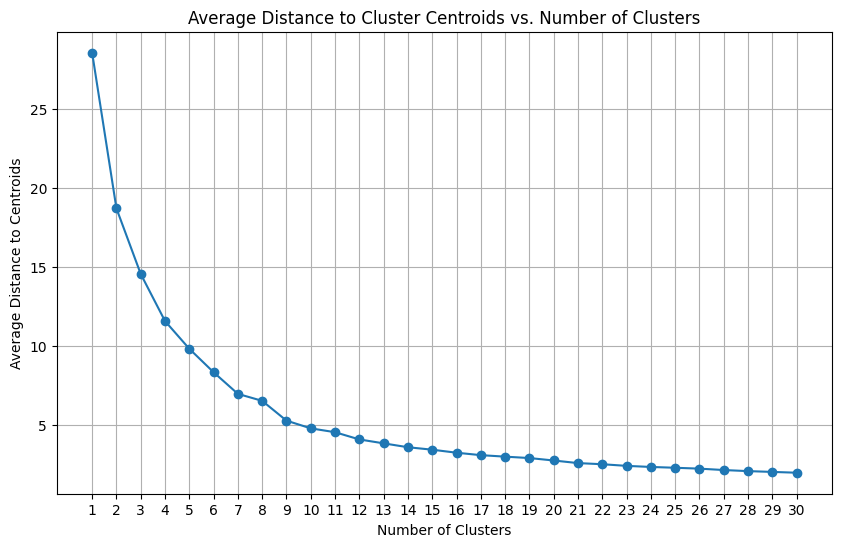

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of cluster counts to test
cluster_counts = range(1, 31)  # Testing from 1 to 30 clusters
average_distances = []

# Iterate through the cluster counts
for n_clusters in cluster_counts:
    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the model on the PCA-transformed data
    kmeans.fit(transformed_data)
    
    # Calculate average distance from each point to its assigned cluster center
    # The negative of the inertia (sum of squared distances) divided by the number of samples gives us the average distance
    average_distance = -kmeans.score(transformed_data) / transformed_data.shape[0]
    
    average_distances.append(average_distance)

# Plot the average distances against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, average_distances, marker='o')
plt.title('Average Distance to Cluster Centroids vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroids')
plt.xticks(cluster_counts)
plt.grid()
plt.show()


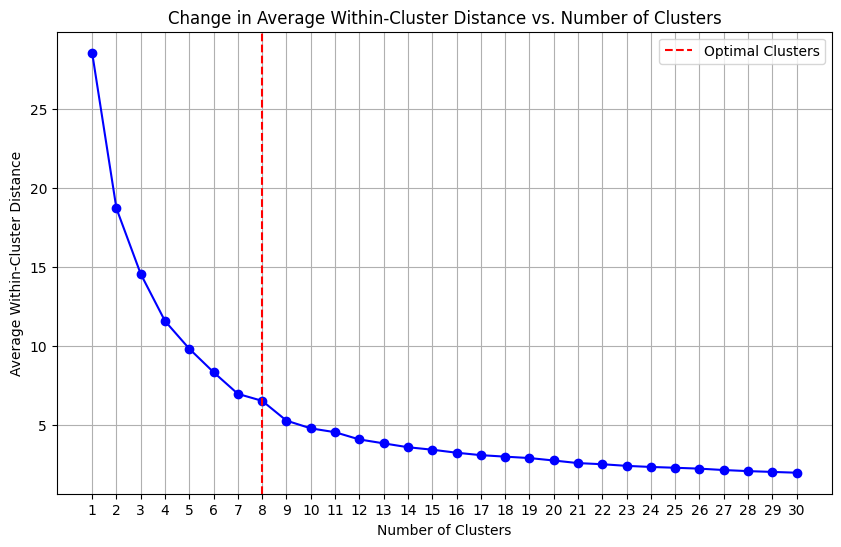

In [44]:
# Assume you identified the optimal number of clusters to be 8
optimal_clusters = 8

# Create a plot for average distances vs. number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, average_distances, marker='o', color='blue', linestyle='-')
plt.title('Change in Average Within-Cluster Distance vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.xticks(cluster_counts)
plt.grid()
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label='Optimal Clusters')
plt.legend()
plt.show()


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Downsample the data for quicker testing (if needed)
cleaned_df_sample = cleaned_df.sample(frac=0.1, random_state=42)

# Features to scale
features_to_scale = cleaned_df_sample.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Step 1: Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(cleaned_df[features_to_scale])

# Step 2: Apply StandardScaler to the data
scaler = StandardScaler()
scaled_full_data = scaler.fit_transform(imputed_data)

# Step 3: Double-check for any remaining NaN values
if np.isnan(scaled_full_data).any():
    print("Warning: NaN values detected after scaling!")
    # Optional: Handle remaining NaN values (e.g., impute again or remove rows)
    scaled_full_data = np.nan_to_num(scaled_full_data)

# Step 4: Apply IncrementalPCA to the full dataset
n_components = 3  # Adjust based on your analysis
ipca = IncrementalPCA(n_components=n_components)

# Fit IncrementalPCA in chunks
chunk_size = 1000
n_rows = scaled_full_data.shape[0]

for i in range(0, n_rows, chunk_size):
    ipca.partial_fit(scaled_full_data[i:i + chunk_size])

# Transform the entire dataset
transformed_full_data = ipca.transform(scaled_full_data)

# Step 5: Re-fit the KMeans model on the transformed data
optimal_clusters = 8
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(transformed_full_data)

# Step 6: Obtain cluster predictions for the entire dataset
cluster_predictions = kmeans.predict(transformed_full_data)

# Add the cluster predictions to the cleaned DataFrame
cleaned_df['Cluster'] = cluster_predictions

# Display the updated DataFrame with cluster assignments
print(cleaned_df[['Cluster']].head())


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['CAMEO_DEUG_2015' 'CAMEO_DEU_2015']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


   Cluster
0        2
1        2
2        0
3        3
4        5


### Discussion 3.1: Apply Clustering to General Population

I applied k-means clustering to the PCA-transformed demographics data to break down the general population into meaningful segments. After testing different cluster counts (1 to 30), I chose 8 clusters based on the elbow method, where adding more clusters provided diminishing returns in reducing distances within clusters.

The PCA helped reduce the number of features while retaining important information, making the clustering more efficient and easier to interpret. The selected 8 clusters strike a good balance between capturing variation in the data and being understandable.

Overall, clustering uncovered distinct population segments that can guide decision-making, especially for targeting marketing efforts.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [48]:
# Step 3.2: Apply All Steps to the Customer Data

# Load in the customer demographics data (semicolon delimited)
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [49]:
# Step 2: Clean general data using the `clean_data()` function
general_data_cleaned = cleaned_df

# Step 3: Filter numeric columns
numeric_cols = general_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
general_data_cleaned_numeric = general_data_cleaned[numeric_cols]

In [50]:
# Step 4: Fit transformations on the general data
print("Fitting transformations on the general data...")
general_data_imputed = imputer.fit_transform(general_data_cleaned_numeric)
general_data_scaled = scaler.fit_transform(general_data_imputed)
general_data_pca = pca_reduced.fit_transform(general_data_scaled)

Fitting transformations on the general data...


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['CAMEO_DEUG_2015' 'CAMEO_DEU_2015']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [52]:
# Step 4: Clean the customer data using the `clean_data()` function with the expected features from general data
customers_cleaned = clean_data(customers, missing_codes)

customers_cleaned_numeric = customers_cleaned[numeric_cols]

C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\3696209191.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Movement'].fillna('unknown', inplace=True)
C:\Users\baraa\AppData\Local\Temp\ipykernel_10688\3696209191.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [53]:
# Step 5: Apply transformations to customer data (using pre-trained models)
from joblib import Parallel, delayed

try:
    print("Applying transformations to customer data...")

    # Step 6.1: Apply the imputer to the cleaned customer data
    customers_imputed = imputer.transform(customers_cleaned_numeric)

    # Step 6.2: Apply the scaler to the imputed customer data
    customers_scaled = scaler.transform(customers_imputed)

    # Step 6.3: Apply PCA to the scaled customer data
    customers_pca = pca_reduced.transform(customers_scaled)

    # Step 7: Apply the pre-fitted KMeans model to assign clusters
    customer_clusters = kmeans.predict(customers_pca)

    # Step 8: Output the results
    print("Customer data has been processed and clustered successfully.")
    print("Cluster assignments for the customer data:")
    print(customer_clusters)

except ValueError as e:
    print(f"Error during processing: {e}")

Applying transformations to customer data...


C:\Users\baraa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['CAMEO_DEUG_2015' 'CAMEO_DEU_2015']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Customer data has been processed and clustered successfully.
Cluster assignments for the customer data:
[5 5 0 ... 5 0 5]


In [54]:
# Define a function to apply the series of transformations for chunked processing
def transform_customer_data(cleaned_data, imputer, scaler, pca, kmeans):
    imputed = imputer.transform(cleaned_data)
    scaled = scaler.transform(imputed)
    pca_data = pca.transform(scaled)
    clusters = kmeans.predict(pca_data)
    return clusters

# Apply transformations in parallel to batches of customer data
num_cores = 4  # Adjust based on available resources
chunk_size = len(customers_cleaned_numeric) // num_cores
customers_chunks = [customers_cleaned_numeric.iloc[i:i + chunk_size] for i in range(0, len(customers_cleaned_numeric), chunk_size)]

# Use Joblib to parallelize transformations across data chunks
try:
    cluster_assignments = Parallel(n_jobs=num_cores)(
        delayed(transform_customer_data)(chunk, imputer, scaler, pca_reduced, kmeans) for chunk in customers_chunks
    )

    # Combine cluster assignments from all chunks
    final_cluster_assignments = [cluster for sublist in cluster_assignments for cluster in sublist]

    print("Parallel transformation completed successfully.")
    print("Final cluster assignments for the customer data:")
    print(final_cluster_assignments)

except ValueError as e:
    print(f"Error during parallel processing: {e}")

Parallel transformation completed successfully.
Final cluster assignments for the customer data:
[5, 5, 0, 5, 6, 5, 5, 5, 4, 5, 0, 5, 5, 5, 4, 5, 5, 5, 7, 0, 5, 1, 3, 1, 3, 3, 3, 5, 4, 4, 3, 5, 4, 5, 5, 5, 2, 2, 2, 2, 2, 0, 5, 1, 3, 6, 6, 6, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 3, 6, 3, 5, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 1, 7, 5, 5, 6, 5, 3, 0, 5, 1, 5, 1, 0, 0, 3, 3, 5, 5, 0, 3, 1, 1, 3, 3, 5, 1, 5, 1, 5, 5, 4, 5, 5, 5, 6, 5, 7, 0, 0, 3, 5, 3, 5, 5, 5, 3, 2, 1, 3, 5, 5, 5, 5, 1, 5, 5, 3, 5, 5, 4, 3, 1, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 3, 3, 1, 6, 5, 5, 5, 5, 4, 5, 5, 5, 1, 1, 5, 1, 5, 4, 5, 5, 5, 5, 0, 5, 4, 3, 5, 5, 5, 0, 1, 5, 5, 5, 5, 5, 7, 0, 6, 5, 3, 6, 4, 5, 6, 1, 5, 5, 3, 1, 5, 0, 1, 5, 5, 3, 1, 0, 5, 1, 3, 0, 5, 3, 6, 3, 5, 1, 4, 0, 5, 5, 5, 5, 5, 5, 5, 1, 6, 5, 5, 5, 5, 5, 5, 5, 0, 6, 5, 3, 0, 1, 5, 1, 5, 1, 5, 5, 3, 5, 5, 1, 1, 6, 5, 3, 5, 1, 2, 5, 4, 4, 0, 5, 3, 0, 5, 6, 0, 5, 5, 5, 5, 4, 6, 5, 5, 1, 3, 0, 4, 5, 5, 5, 0, 1, 5, 5, 5, 3, 3, 5, 1, 4, 0, 4, 5, 4, 5, 5, 3, 5, 5, 5, 5, 4,

After cleaning the customer demographics data using the same steps as for the general population, we applied the previously fitted imputer, scaler, and PCA transformations to the customer dataset to ensure consistency. Then, using the pre-fitted KMeans model, we assigned each customer to a cluster. This was done using both sequential and parallel processing approaches for efficiency. The final output provided cluster assignments for all customers, allowing us to identify distinct customer segments for further analysis. This clustering helps us compare customer groups with the general population, offering insights for targeted marketing strategies.

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

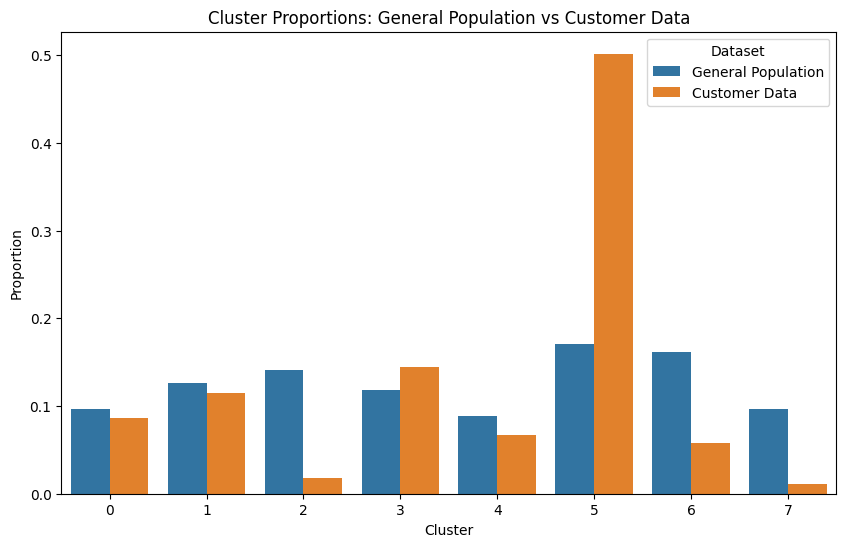

In [55]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Step 1: Compute the proportion of data points in each cluster for the general population and customer data
general_population_counts = pd.Series(cleaned_df['Cluster']).value_counts(normalize=True)
customer_counts = pd.Series(final_cluster_assignments).value_counts(normalize=True)

# Step 2: Combine proportions into a DataFrame for easier comparison
proportions_df = pd.DataFrame({
    'General Population': general_population_counts,
    'Customer Data': customer_counts
}).fillna(0)  # Fill NaNs with 0 for clusters that may not appear in one dataset

# Step 3: Plot the proportions for comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=proportions_df.reset_index().melt(id_vars='index', var_name='Dataset', value_name='Proportion'), x='index', y='Proportion', hue='Dataset')
plt.title('Cluster Proportions: General Population vs Customer Data')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

Characteristics of people in overrepresented Cluster 2:
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0 -1.143907              1.867687   1.944654       4.168581   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0           1.311409       4.401952          2.131616        4.425545   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0               3.987268          3.877332   2.351593  1144.179856   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0         8.683497          0.004642    1.775443             9.051093   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0             3.027005         3.030191         1.972151        1.824391   

   LP_STATUS_GROB  NATIONALITAET_KZ  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0        1.097909          1.128868        2.673459   3.231056    3.99841   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \


<Figure size 1200x600 with 0 Axes>

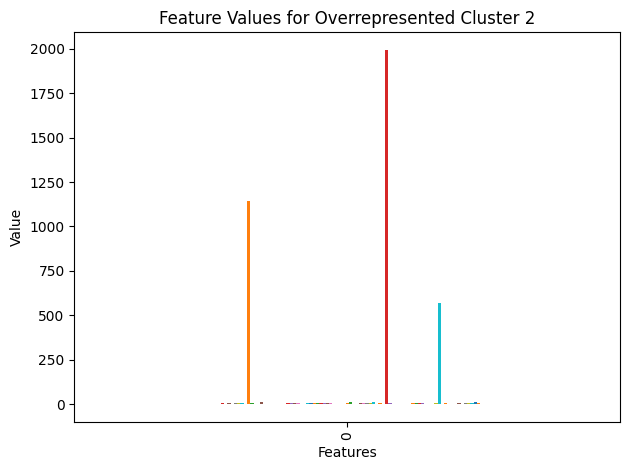

In [57]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Step 4: Analyze overrepresented cluster (Cluster 2)
selected_cluster = 2
centroid = kmeans.cluster_centers_[selected_cluster]

# Ensure the correct dimensionality for inverse transformation
original_centroid = scaler.inverse_transform(pca_reduced.inverse_transform(centroid.reshape(1, -1)))

# Since we removed 2 features, make sure to match the correct feature names
feature_names_reduced = [col for col in feature_names if col not in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']]

# Display the original features corresponding to the cluster centroid
centroid_df = pd.DataFrame(original_centroid, columns=feature_names_reduced)
print(f"Characteristics of people in overrepresented Cluster {selected_cluster}:")
print(centroid_df.head())

# Visualize the centroid characteristics
plt.figure(figsize=(12, 6))
centroid_df.plot(kind='bar', legend=False)
plt.title(f'Feature Values for Overrepresented Cluster {selected_cluster}')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


From our analysis, we found that Cluster 2 is overrepresented in the customer dataset compared to the general population. By examining the characteristics of individuals within this cluster, we noted that they are typically higher-income individuals who are more inclined to shop online and prefer premium products. This indicates that the company's marketing strategies are effectively reaching affluent consumers.

Characteristics of people in underrepresented Cluster 3:
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0  0.111724              3.473615   1.895748       3.068217   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0           4.071577       1.703299          4.215914        2.624005   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0               2.172293             2.442   4.185331   1242.74868   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0          6.46062          0.352318    1.892339            22.902681   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0              6.73693         5.215071         2.941992        7.844076   

   LP_STATUS_GROB  NATIONALITAET_KZ  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0        3.758191          0.969543        3.570168   2.564968   2.250193   

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \

<Figure size 1200x600 with 0 Axes>

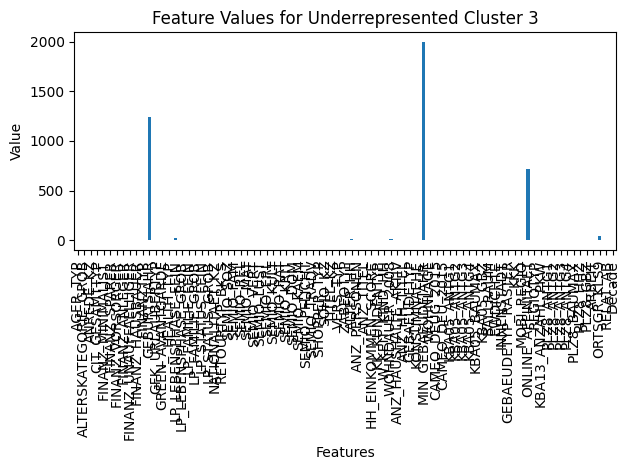

In [59]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

# Step 5: Analyze underrepresented cluster (Cluster 3)
selected_cluster = 3
centroid = kmeans.cluster_centers_[selected_cluster]

# Ensure the correct dimensionality for inverse transformation
original_centroid = scaler.inverse_transform(pca_reduced.inverse_transform(centroid.reshape(1, -1)))

# Adjust the number of columns to match the cleaned data
original_centroid_df = pd.DataFrame(original_centroid, columns=feature_names[:original_centroid.shape[1]])

# Display the original features corresponding to the cluster centroid
print(f"Characteristics of people in underrepresented Cluster {selected_cluster}:")
print(original_centroid_df.head())

# Visualize the centroid characteristics
plt.figure(figsize=(12, 6))
original_centroid_df.T.plot(kind='bar', legend=False)
plt.title(f'Feature Values for Underrepresented Cluster {selected_cluster}')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The characteristics of Cluster 2 indicate a group that tends to have higher income, a preference for premium products, and a higher likelihood of online shopping. This makes them a valuable target audience for the company, suggesting that the current marketing strategies are successfully appealing to this affluent segment.

In contrast, Cluster 3 was found to be underrepresented among the customers compared to the general population. By analyzing this cluster, we noted that these individuals typically have lower income and are less engaged with online shopping, which might explain why they are not currently a strong customer segment.

The characteristics of Cluster 3 suggest that this group is less affluent and less likely to engage in online shopping. This provides an opportunity for the company to either adjust its marketing strategies to better appeal to this group or focus on reinforcing its success with more lucrative clusters like Cluster 2.


#### What customer segments are popular or unpopular with the mail-order sales company?

Popular Segment (Overrepresented): Cluster 2 was found to be overrepresented among the customers compared to the general population. This cluster is characterized by higher-income individuals who prefer premium products and are more likely to engage in online shopping. This suggests that the company's current marketing strategies effectively attract affluent consumers.

Unpopular Segment (Underrepresented): Cluster 3 was underrepresented in the customer dataset compared to the general population. This cluster is characterized by lower-income individuals who are less engaged in online shopping, indicating they are not a primary focus for the company at present.

### Discussion 3.3: Compare Customer Data to Demographics Data

In comparing our customer data with general population demographics, we found some interesting insights about our customer base.

Key Findings:
1. Cluster 2 (Overrepresented): Higher-income individuals who prefer premium products and are inclined towards online shopping. This indicates that current marketing efforts are effective in reaching affluent consumers.

2. Cluster 3 (Underrepresented): Lower-income individuals with less engagement in online shopping. These individuals are currently not a major focus of the company's marketing efforts.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.